# Individual Exploration Abby: Path 2 - Strategy Execution Analysis

## INSY 6500 – Individual Exploration (Path 2)

### Analyst: Abby Tucker
**Objective:** Validate data quality, analyze missingness drivers, classify structural vs. category-driven missingness, and prepare data for strategic analysis.

**Datasets:**
- `101ki_pm_performance.csv` - 12-month historical performance (April 2024 - March 2025)
- `103ki_pm_forecast.csv` - 12-month PM forecast (April 2026 - March 2027)

---

### Step 1 Imports & Load Data 

##### 1.1 Imports 

In [1]:
# Standard imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import pandas as pd

print("Libraries imported")

Libraries imported


##### 1.2 Load Performance and Forecast Data

In [2]:
# Define data directory
DATA_DIR = Path('../data')

# Define file paths
PERFORMANCE_FILE = DATA_DIR / '101ki_pm_performance.csv'
FORECAST_FILE = DATA_DIR / '103ki_pm_forecast.csv'

# Load historical performance data
df_performance = pd.read_csv(PERFORMANCE_FILE)
print(f"Performance data shape: {df_performance.shape[0]:,} rows, {df_performance.shape[1]} columns")

#Load scheduled maintenance data
df_forecast = pd.read_csv(FORECAST_FILE, 
                        encoding='cp1252',
                        parse_dates = ['DUE_DATE'],
                        dtype={
                            'INTERVAL': 'category',
                            'JOB_TYPE': 'category',
                            'LABOR_CRAFT': 'category',
                            'PMSCOPETYPE': 'category',
                            'DEPT': 'category',
                            'DEPT_NAME': 'category',
                            'DEPT_TYPE' : 'category',
                            'PLANT' : 'category',
                            'LINE' : 'category',
                            'ZONENAME' : 'category',
                            'PROCESSNAME' : 'category'
                        })

# Fix missing DEPT_NAME for Facilities departments
df_forecast['DEPT_NAME'] = np.where(
    df_forecast['DEPT'].str.startswith('FA', na=False) & df_forecast['DEPT_NAME'].isna(),
    'FACILITIES',
    df_forecast['DEPT_NAME'])

print(f"Forecast data shape: {df_forecast.shape[0]:,} rows, {df_forecast.shape[1]} columns")

Performance data shape: 18,476 rows, 7 columns
Forecast data shape: 99,983 rows, 23 columns


In [3]:
# Checking data upload
print(df_performance.info(), df_performance.isna().sum())
print(df_forecast.info(), df_forecast.isna().sum())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18476 entries, 0 to 18475
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   PMNUM                18476 non-null  object 
 1   TIMES_SCHEDULED      18476 non-null  int64  
 2   TIMES_ONTIME         18476 non-null  int64  
 3   TIMES_LATE           18476 non-null  int64  
 4   TIMES_NOT_COMPLETED  18476 non-null  int64  
 5   AVG_PLANNED_HRS      18476 non-null  float64
 6   AVG_ACTUAL_HRS       18476 non-null  float64
dtypes: float64(2), int64(4), object(1)
memory usage: 1010.5+ KB
None PMNUM                  0
TIMES_SCHEDULED        0
TIMES_ONTIME           0
TIMES_LATE             0
TIMES_NOT_COMPLETED    0
AVG_PLANNED_HRS        0
AVG_ACTUAL_HRS         0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99983 entries, 0 to 99982
Data columns (total 23 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------    

### Step 2 Mergeing Data Sets & Verification

##### 2.1 Data Merge

In [4]:
# Data merge done with outer to account for PMNUM difference between data sets to prevent data loss
performance_forecast = pd.merge(df_performance, df_forecast, on='PMNUM', how='outer', indicator=True)

# Checking mergered data set 
performance_forecast.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 102021 entries, 0 to 102020
Data columns (total 30 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   PMNUM                   102021 non-null  object        
 1   TIMES_SCHEDULED         96156 non-null   float64       
 2   TIMES_ONTIME            96156 non-null   float64       
 3   TIMES_LATE              96156 non-null   float64       
 4   TIMES_NOT_COMPLETED     96156 non-null   float64       
 5   AVG_PLANNED_HRS         96156 non-null   float64       
 6   AVG_ACTUAL_HRS          96156 non-null   float64       
 7   DUE_DATE                99983 non-null   datetime64[ns]
 8   COUNTKEY                99983 non-null   object        
 9   PMDESCRIPTION           99983 non-null   object        
 10  INTERVAL                99983 non-null   category      
 11  FORECASTJP              99910 non-null   object        
 12  JOB_TYPE                99906 

##### 2.2 Verification of Merge: Missing Keys & Shape

In [5]:
# Checking for lost keys
pmnum_lost_from_performance = set(df_performance["PMNUM"]) - set(performance_forecast["PMNUM"])
pmnum_lost_from_forecast   = set(df_forecast["PMNUM"]) - set(performance_forecast["PMNUM"])

print("Keys Lost from performance:", len(pmnum_lost_from_performance))
print("Keys Lost from forecast:", len(pmnum_lost_from_forecast))

# Comparing data set shapes 
print()
print("=" * 80)
print("Merged Data Shape:", f"   Rows: {performance_forecast.shape[0]:,}", f"   Columns: {performance_forecast.shape[1]}")
print("Orginal Performance Shape:", f"   Rows: {df_performance.shape[0]:,}", f"   Columns: {df_performance.shape[1]}")
print("Orginal Forecast Shape:", f"   Rows: {df_forecast.shape[0]:,}", f"   Columns: {df_forecast.shape[1]}")
print("=" * 80)



Keys Lost from performance: 0
Keys Lost from forecast: 0

Merged Data Shape:    Rows: 102,021    Columns: 30
Orginal Performance Shape:    Rows: 18,476    Columns: 7
Orginal Forecast Shape:    Rows: 99,983    Columns: 23


From previous data exploration, we know that:
* 2,038 PMNUMs from last year won't repeat next year (PMNUM only in Performance)
* 1,911 new PMNUMs in Forecast that are not in performance data (PMNUM only in Forecast)
* Forecast data set has 23 columns and 99,983rows
* Performance data set has 7 columns and 18,476 rows
  
When merging the data sets, we would expect:
* More rows than in either dataset 
* The number of columns to increase by 6 (not including the merge indication column)
* The number of rows to increase by 2,038 (when adding Performance to the Forecast) 

Merge Result Based on Shape: 
* Columns increased by 6 (23 &rarr; 29)
* Rows increased by 2,038 (99,983 &rarr; 102,021)

##### 2.3 Merge Verificaion: Missing Data Check

In [6]:
# Missing data verification 
orig_perf_missing   = df_performance.isna().sum()
orig_forecast_missing = df_forecast.isna().sum()

# Finding PMNUMs missing values from the  forecast dataset
forecast_missing_mask = performance_forecast['_merge'].isin(['left_only'])
    
pmnum_missing_forecast = performance_forecast.loc[forecast_missing_mask, 'PMNUM']

# Finding PMNUMs' missing values from the performance dataset
performance_missing_mask = performance_forecast['_merge'].isin(['right_only'])
pmnum_missing_performance = performance_forecast.loc[performance_missing_mask, 'PMNUM']

# Checking other columns for missing values in the performance  dataset 
performance_cols = df_performance.columns
perf_row_mask = performance_forecast["_merge"].isin(["both", "left_only"])
missing_performance =  performance_forecast.loc[perf_row_mask, performance_cols].isna().sum() 

# Checking other columns for missing values in the forecast dataset 
forecast_cols = df_forecast.columns
forecast_row_mask = performance_forecast["_merge"].isin(["both", "right_only"])
missing_forecast =  performance_forecast.loc[forecast_row_mask, forecast_cols].isna().sum()

print("Missing Data in Merged Dataset:")
print()
print("Number of Maintiance Identifiers Missing Forcast Data:", pmnum_missing_forecast.nunique())
print("Number of Maintiance Identifiers Missing Perfromance Data:", pmnum_missing_performance.nunique())
print()
print("Missing Data in Mergered Dataset form Forecast Data:\n", missing_forecast[missing_forecast > 0])
print("For comparison Orginal Missing: \n", orig_forecast_missing[orig_forecast_missing > 0]) 
print()
print("Missing Data in Mergered Dataset form Performance Data:\n", missing_performance)
print("For comparison Orginal Missing:\n",orig_perf_missing)




Missing Data in Merged Dataset:

Number of Maintiance Identifiers Missing Forcast Data: 2038
Number of Maintiance Identifiers Missing Perfromance Data: 1911

Missing Data in Mergered Dataset form Forecast Data:
 FORECASTJP                   73
JOB_TYPE                     77
LABOR_CRAFT                7882
PLANNED_LABORERS            829
PLANNED_LABOR_HRS           829
TOTAL_MATERIAL_COST       98051
TOTAL_TASK_DESC_LENGTH      104
LINE                       1727
PROCESSNAME               14404
dtype: int64
For comparison Orginal Missing: 
 FORECASTJP                   73
JOB_TYPE                     77
LABOR_CRAFT                7882
PLANNED_LABORERS            829
PLANNED_LABOR_HRS           829
TOTAL_MATERIAL_COST       98051
TOTAL_TASK_DESC_LENGTH      104
LINE                       1727
PROCESSNAME               14404
dtype: int64

Missing Data in Mergered Dataset form Performance Data:
 PMNUM                  0
TIMES_SCHEDULED        0
TIMES_ONTIME           0
TIMES_LATE         

#### Takeaways 
* Missing data in the merged data set matches that of the original data sets when looking at the merged data set. 
* No data was lost during the merge. 
* Merge was successful.

### Step 3 Set Working Dataframe

In [7]:
df = performance_forecast.copy()
cols_to_drop = ["TOTAL_MATERIAL_COST"]
df = df.drop(columns=cols_to_drop, errors="ignore")
print("Column still present?", "TOTAL_MATERIAL_COST" in df.columns)

df.info()

Column still present? False
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 102021 entries, 0 to 102020
Data columns (total 29 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   PMNUM                   102021 non-null  object        
 1   TIMES_SCHEDULED         96156 non-null   float64       
 2   TIMES_ONTIME            96156 non-null   float64       
 3   TIMES_LATE              96156 non-null   float64       
 4   TIMES_NOT_COMPLETED     96156 non-null   float64       
 5   AVG_PLANNED_HRS         96156 non-null   float64       
 6   AVG_ACTUAL_HRS          96156 non-null   float64       
 7   DUE_DATE                99983 non-null   datetime64[ns]
 8   COUNTKEY                99983 non-null   object        
 9   PMDESCRIPTION           99983 non-null   object        
 10  INTERVAL                99983 non-null   category      
 11  FORECASTJP              99910 non-null   object        
 12  JO

### Step 4 Data Quality Assessment 

##### 4.1 Shape and Data Types 

In [8]:
# Data Type verification 
print(performance_forecast.shape)
print(performance_forecast.dtypes)


(102021, 30)
PMNUM                             object
TIMES_SCHEDULED                  float64
TIMES_ONTIME                     float64
TIMES_LATE                       float64
TIMES_NOT_COMPLETED              float64
AVG_PLANNED_HRS                  float64
AVG_ACTUAL_HRS                   float64
DUE_DATE                  datetime64[ns]
COUNTKEY                          object
PMDESCRIPTION                     object
INTERVAL                        category
FORECASTJP                        object
JOB_TYPE                        category
LABOR_CRAFT                     category
PLANNED_LABORERS                 float64
PLANNED_LABOR_HRS                float64
TOTAL_MATERIAL_COST              float64
TASK_COUNT                       float64
TOTAL_TASK_DESC_LENGTH           float64
PMSCOPETYPE                     category
LOCATION                          object
LOCATIONDESC                      object
PLANT                           category
DEPT                            category
DEP

#### Takeaway
* Data types match the expexed types 

##### 4.2 Column-Level Missingness

In [9]:
# Missing Data Analysis
missing_mask = performance_forecast.isna()
missing = missing_mask.sum().to_frame(name="count")
missing['precentage'] = (missing['count']/performance_forecast.shape[0])

missing.style.format({'precentage': "{:.1%}"})

,count,precentage
PMNUM,0,0.0%
TIMES_SCHEDULED,5865,5.7%
TIMES_ONTIME,5865,5.7%
TIMES_LATE,5865,5.7%
TIMES_NOT_COMPLETED,5865,5.7%
AVG_PLANNED_HRS,5865,5.7%
AVG_ACTUAL_HRS,5865,5.7%
DUE_DATE,2038,2.0%
COUNTKEY,2038,2.0%
PMDESCRIPTION,2038,2.0%


##### 4.2.1 Missingness Heatmap

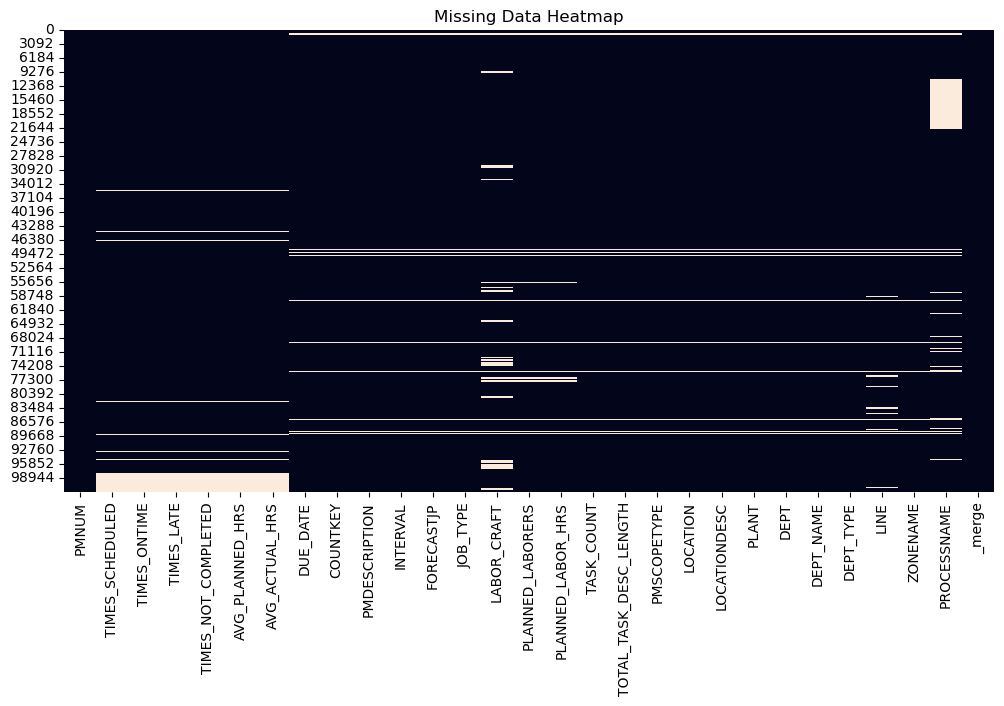

In [10]:
# Visualization of Missing Data

plt.figure(figsize=(12,6))
sns.heatmap(df.isna(), cbar=False)
plt.title("Missing Data Heatmap")
plt.show()

### Takeaways
* The missing data percentage is relatively low, between 2.0% and 6.0% for most of the data
* Process Name has about 16% missing data
    * Is a string that provides names, less important for analysis
    * Still usable for analysis
* Labor Craft has about 9% missing data
    * Categorizes the required labor skill/craft to perform maintenance
    * Still usable for analysis

##### 4.3 Duplicated Rows Check

In [11]:
# Fully duplicated rows
n_duplicates = df.duplicated().sum()
print("Fully duplicated rows:", n_duplicates)

if n_duplicates > 0:
    display(df[df.duplicated(keep=False)].head())


Fully duplicated rows: 5460


,PMNUM,TIMES_SCHEDULED,TIMES_ONTIME,TIMES_LATE,TIMES_NOT_COMPLETED,AVG_PLANNED_HRS,AVG_ACTUAL_HRS,DUE_DATE,COUNTKEY,PMDESCRIPTION,...,LOCATION,LOCATIONDESC,PLANT,DEPT,DEPT_NAME,DEPT_TYPE,LINE,ZONENAME,PROCESSNAME,_merge
5013,PM101736,2.0,2.0,0.0,0.0,32.0,23.5,2026-06-30,2026-06-30-PM101736,TIRE CONVEYOR - SEMI ANNUAL,...,1AF1TLTCDSCV,Tire Conveyor System TIRE DESTACK TIRE DESTAC...,1,1AF,FRAME ASSEMBLY 1,AF,1,Tire Line,Tire Install,both
5014,PM101736,2.0,2.0,0.0,0.0,32.0,23.5,2026-06-30,2026-06-30-PM101736,TIRE CONVEYOR - SEMI ANNUAL,...,1AF1TLTCDSCV,Tire Conveyor System TIRE DESTACK TIRE DESTAC...,1,1AF,FRAME ASSEMBLY 1,AF,1,Tire Line,Tire Install,both
5015,PM101736,2.0,2.0,0.0,0.0,32.0,23.5,2026-12-30,2026-12-30-PM101736,TIRE CONVEYOR - SEMI ANNUAL,...,1AF1TLTCDSCV,Tire Conveyor System TIRE DESTACK TIRE DESTAC...,1,1AF,FRAME ASSEMBLY 1,AF,1,Tire Line,Tire Install,both
5016,PM101736,2.0,2.0,0.0,0.0,32.0,23.5,2026-12-30,2026-12-30-PM101736,TIRE CONVEYOR - SEMI ANNUAL,...,1AF1TLTCDSCV,Tire Conveyor System TIRE DESTACK TIRE DESTAC...,1,1AF,FRAME ASSEMBLY 1,AF,1,Tire Line,Tire Install,both
9121,PM103853,12.0,8.0,4.0,0.0,0.5,0.5,2026-04-28,2026-04-28-PM103853,BUMPER SURFACER ROBOT 1.1 MONTHLY PM,...,2BP2PMBORSSA,Booth Robot System Surfacer Robot S1-1,2,2BP,BUMPER PAINT 2,BP,2,Paint Mix,Paint Mix Booth,both


##### 4.4 Column Uniqueness / Repetiton

In [12]:
# Duplication detection 
performance_forecast_dups = performance_forecast.nunique().to_frame(name = 'unique_vals')
performance_forecast_dups['duplicates'] = performance_forecast.shape[0] - performance_forecast_dups['unique_vals']
performance_forecast_dups['precentage'] = performance_forecast_dups['duplicates'] / performance_forecast.shape[0]

display(performance_forecast_dups.style.format({'precentage': "{:.1%}"}))

,unique_vals,duplicates,precentage
PMNUM,20387,81634,80.0%
TIMES_SCHEDULED,50,101971,100.0%
TIMES_ONTIME,67,101954,99.9%
TIMES_LATE,26,101995,100.0%
TIMES_NOT_COMPLETED,10,102011,100.0%
AVG_PLANNED_HRS,389,101632,99.6%
AVG_ACTUAL_HRS,1381,100640,98.6%
DUE_DATE,364,101657,99.6%
COUNTKEY,89264,12757,12.5%
PMDESCRIPTION,17383,84638,83.0%


#### Takeaways 
* Due to the nature of the forecast data, duplication is expected
* Keeping duplications as data is a schedule for maintenance, and having duplicate (repeated) maintenance needs is reasonable
* Can use the maintenance due date  and interval frequency as a way to deal with duplications of unique preventive maintenance identifier

##### 4.5 Cleaning Categorical Variables

In [13]:
# Identify all object or categorical string-like columns
cat_cols = df.select_dtypes(include=["object", "string", "category"]).columns

print("Cleaning these columns:", list(cat_cols))

# Clean whitespace & normalize text
for col in cat_cols:
    df[col] = (df[col]
               .astype("string")      # ensure pandas string dtype
               .str.strip()           # remove leading/trailing spaces
               .str.replace(r"\s+", " ", regex=True)  # collapse multi-spaces
              )

# Show result
print("\nUnique levels after cleaning:")
for col in cat_cols:
    print(f"{col}: {df[col].nunique()}")


Cleaning these columns: ['PMNUM', 'COUNTKEY', 'PMDESCRIPTION', 'INTERVAL', 'FORECASTJP', 'JOB_TYPE', 'LABOR_CRAFT', 'PMSCOPETYPE', 'LOCATION', 'LOCATIONDESC', 'PLANT', 'DEPT', 'DEPT_NAME', 'DEPT_TYPE', 'LINE', 'ZONENAME', 'PROCESSNAME', '_merge']

Unique levels after cleaning:
PMNUM: 20387
COUNTKEY: 89264
PMDESCRIPTION: 17379
INTERVAL: 47
FORECASTJP: 3669
JOB_TYPE: 5
LABOR_CRAFT: 29
PMSCOPETYPE: 3
LOCATION: 3568
LOCATIONDESC: 3451
PLANT: 4
DEPT: 27
DEPT_NAME: 18
DEPT_TYPE: 22
LINE: 19
ZONENAME: 180
PROCESSNAME: 476
_merge: 3


### Takeaways
* This cleaned the string variables do that the strings are all formated the same. 

##### 4.6 Missingness by Category

In [14]:
#Looking at missingness by categorical data 
# Set up
categorical_cols = [ 'INTERVAL', 'JOB_TYPE', 'LABOR_CRAFT', 'PMSCOPETYPE', 'DEPT',
                     'DEPT_NAME', 'DEPT_TYPE', 'PLANT', 'LINE', 'ZONENAME', 'PROCESSNAME']

existing_cats = [c for c in categorical_cols if c in df.columns]

# Function
def missingness_rate_by_category(df, categorical_cols):
    results = {}
    for cat in categorical_cols:
        if cat not in df.columns:
            continue
        df_no_cat = df.drop(columns=[cat])
        missing_by_cat = (df_no_cat
            .groupby(df[cat], observed=True)
            .apply(lambda g: g.isna().mean() * 100))
        results[cat] = missing_by_cat
    return results
missing_rate_tables = missingness_rate_by_category(df, existing_cats)

for cat, table in missing_rate_tables.items():
    print(f"\n### Missingness by: {cat}")
    display(table.head())



### Missingness by: INTERVAL


,PMNUM,TIMES_SCHEDULED,TIMES_ONTIME,TIMES_LATE,TIMES_NOT_COMPLETED,AVG_PLANNED_HRS,AVG_ACTUAL_HRS,DUE_DATE,COUNTKEY,PMDESCRIPTION,...,LOCATION,LOCATIONDESC,PLANT,DEPT,DEPT_NAME,DEPT_TYPE,LINE,ZONENAME,PROCESSNAME,_merge
INTERVAL,,,,,,,,,,,,,,,,,,,,,
1-DAYS,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,98.260870,0.0
1-MONTHS,0.0,2.610903,2.610903,2.610903,2.610903,2.610903,2.610903,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.450502,0.0,7.019824,0.0
1-WEEKS,0.0,8.034335,8.034335,8.034335,8.034335,8.034335,8.034335,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,13.608011,0.0
1-YEARS,0.0,11.141135,11.141135,11.141135,11.141135,11.141135,11.141135,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.935356,0.0,13.282062,0.0
10-MONTHS,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0



### Missingness by: JOB_TYPE


,PMNUM,TIMES_SCHEDULED,TIMES_ONTIME,TIMES_LATE,TIMES_NOT_COMPLETED,AVG_PLANNED_HRS,AVG_ACTUAL_HRS,DUE_DATE,COUNTKEY,PMDESCRIPTION,...,LOCATION,LOCATIONDESC,PLANT,DEPT,DEPT_NAME,DEPT_TYPE,LINE,ZONENAME,PROCESSNAME,_merge
JOB_TYPE,,,,,,,,,,,,,,,,,,,,,
ADJUSTMENT,0.0,9.462544,9.462544,9.462544,9.462544,9.462544,9.462544,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.020751,0.0,26.509649,0.0
INSPECTION,0.0,5.761232,5.761232,5.761232,5.761232,5.761232,5.761232,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.778533,0.0,14.865332,0.0
NONASSET,0.0,3.128153,3.128153,3.128153,3.128153,3.128153,3.128153,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,17.810293,0.0,26.236125,0.0
PREDICTIVE,0.0,7.356063,7.356063,7.356063,7.356063,7.356063,7.356063,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.061571,0.0,6.819033,0.0
REPAIR,0.0,1.541182,1.541182,1.541182,1.541182,1.541182,1.541182,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.202122,0.0



### Missingness by: LABOR_CRAFT


,PMNUM,TIMES_SCHEDULED,TIMES_ONTIME,TIMES_LATE,TIMES_NOT_COMPLETED,AVG_PLANNED_HRS,AVG_ACTUAL_HRS,DUE_DATE,COUNTKEY,PMDESCRIPTION,...,LOCATION,LOCATIONDESC,PLANT,DEPT,DEPT_NAME,DEPT_TYPE,LINE,ZONENAME,PROCESSNAME,_merge
LABOR_CRAFT,,,,,,,,,,,,,,,,,,,,,
CONELEC,0.0,83.333333,83.333333,83.333333,83.333333,83.333333,83.333333,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,16.666667,0.0,0.000000,0.0
CONGEN,0.0,1.064721,1.064721,1.064721,1.064721,1.064721,1.064721,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.047853,0.0,85.985166,0.0
CONTMECH,0.0,1.284797,1.284797,1.284797,1.284797,1.284797,1.284797,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0
DIESERV,0.0,34.951456,34.951456,34.951456,34.951456,34.951456,34.951456,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0
EGELEC,0.0,83.823529,83.823529,83.823529,83.823529,83.823529,83.823529,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.980392,0.0



### Missingness by: PMSCOPETYPE


,PMNUM,TIMES_SCHEDULED,TIMES_ONTIME,TIMES_LATE,TIMES_NOT_COMPLETED,AVG_PLANNED_HRS,AVG_ACTUAL_HRS,DUE_DATE,COUNTKEY,PMDESCRIPTION,...,LOCATION,LOCATIONDESC,PLANT,DEPT,DEPT_NAME,DEPT_TYPE,LINE,ZONENAME,PROCESSNAME,_merge
PMSCOPETYPE,,,,,,,,,,,,,,,,,,,,,
ASSET,0.0,5.333016,5.333016,5.333016,5.333016,5.333016,5.333016,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,16.312756,0.0
LOCATION,0.0,9.936430,9.936430,9.936430,9.936430,9.936430,9.936430,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,4.772616,0.0,0.000000,0.0
ROUTE,0.0,9.595613,9.595613,9.595613,9.595613,9.595613,9.595613,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,84.921179,0.0,0.000000,0.0



### Missingness by: DEPT


,PMNUM,TIMES_SCHEDULED,TIMES_ONTIME,TIMES_LATE,TIMES_NOT_COMPLETED,AVG_PLANNED_HRS,AVG_ACTUAL_HRS,DUE_DATE,COUNTKEY,PMDESCRIPTION,...,PMSCOPETYPE,LOCATION,LOCATIONDESC,PLANT,DEPT_NAME,DEPT_TYPE,LINE,ZONENAME,PROCESSNAME,_merge
DEPT,,,,,,,,,,,,,,,,,,,,,
1AF,0.0,3.205645,3.205645,3.205645,3.205645,3.205645,3.205645,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.008065,0.0,0.0,0.0
1BP,0.0,1.264223,1.264223,1.264223,1.264223,1.264223,1.264223,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
1ME,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,100.000000,0.0,0.0,0.0
1PA,0.0,4.017660,4.017660,4.017660,4.017660,4.017660,4.017660,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.022075,0.0,0.0,0.0
1PE,0.0,2.150538,2.150538,2.150538,2.150538,2.150538,2.150538,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.537634,0.0,0.0,0.0



### Missingness by: DEPT_NAME


,PMNUM,TIMES_SCHEDULED,TIMES_ONTIME,TIMES_LATE,TIMES_NOT_COMPLETED,AVG_PLANNED_HRS,AVG_ACTUAL_HRS,DUE_DATE,COUNTKEY,PMDESCRIPTION,...,PMSCOPETYPE,LOCATION,LOCATIONDESC,PLANT,DEPT,DEPT_TYPE,LINE,ZONENAME,PROCESSNAME,_merge
DEPT_NAME,,,,,,,,,,,,,,,,,,,,,
BUMPER PAINT 1,0.0,1.264223,1.264223,1.264223,1.264223,1.264223,1.264223,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.00000,0.0
BUMPER PAINT 2,0.0,10.784314,10.784314,10.784314,10.784314,10.784314,10.784314,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.633987,0.0,0.00000,0.0
DIE CAST,0.0,0.508906,0.508906,0.508906,0.508906,0.508906,0.508906,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.00000,0.0
ENGINE ASSEMBLY,0.0,7.078225,7.078225,7.078225,7.078225,7.078225,7.078225,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,4.611792,0.0,0.00000,0.0
FACILITIES,0.0,0.784769,0.784769,0.784769,0.784769,0.784769,0.784769,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,98.22574,0.0



### Missingness by: DEPT_TYPE


,PMNUM,TIMES_SCHEDULED,TIMES_ONTIME,TIMES_LATE,TIMES_NOT_COMPLETED,AVG_PLANNED_HRS,AVG_ACTUAL_HRS,DUE_DATE,COUNTKEY,PMDESCRIPTION,...,PMSCOPETYPE,LOCATION,LOCATIONDESC,PLANT,DEPT,DEPT_NAME,LINE,ZONENAME,PROCESSNAME,_merge
DEPT_TYPE,,,,,,,,,,,,,,,,,,,,,
A0,0.0,0.847846,0.847846,0.847846,0.847846,0.847846,0.847846,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,98.014054,0.0
AD,0.0,0.809717,0.809717,0.809717,0.809717,0.809717,0.809717,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,100.000000,0.0
AE,0.0,7.078225,7.078225,7.078225,7.078225,7.078225,7.078225,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,4.611792,0.0,0.000000,0.0
AF,0.0,3.542545,3.542545,3.542545,3.542545,3.542545,3.542545,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.706231,0.0,0.000000,0.0
AG,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,100.000000,0.0



### Missingness by: PLANT


,PMNUM,TIMES_SCHEDULED,TIMES_ONTIME,TIMES_LATE,TIMES_NOT_COMPLETED,AVG_PLANNED_HRS,AVG_ACTUAL_HRS,DUE_DATE,COUNTKEY,PMDESCRIPTION,...,PMSCOPETYPE,LOCATION,LOCATIONDESC,DEPT,DEPT_NAME,DEPT_TYPE,LINE,ZONENAME,PROCESSNAME,_merge
PLANT,,,,,,,,,,,,,,,,,,,,,
1,0.0,8.341941,8.341941,8.341941,8.341941,8.341941,8.341941,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.691771,0.0,0.031302,0.0
2,0.0,5.756219,5.756219,5.756219,5.756219,5.756219,5.756219,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2.960199,0.0,0.000000,0.0
3,0.0,5.848885,5.848885,5.848885,5.848885,5.848885,5.848885,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2.397208,0.0,0.000000,0.0
F,0.0,0.784769,0.784769,0.784769,0.784769,0.784769,0.784769,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,98.225740,0.0



### Missingness by: LINE


,PMNUM,TIMES_SCHEDULED,TIMES_ONTIME,TIMES_LATE,TIMES_NOT_COMPLETED,AVG_PLANNED_HRS,AVG_ACTUAL_HRS,DUE_DATE,COUNTKEY,PMDESCRIPTION,...,PMSCOPETYPE,LOCATION,LOCATIONDESC,PLANT,DEPT,DEPT_NAME,DEPT_TYPE,ZONENAME,PROCESSNAME,_merge
LINE,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.171906,0.171906,0.171906,0.171906,0.171906,0.171906,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,90.864440,0.0
1,0.0,7.308821,7.308821,7.308821,7.308821,7.308821,7.308821,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11.925066,0.0
2,0.0,5.387780,5.387780,5.387780,5.387780,5.387780,5.387780,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.695246,0.0
3,0.0,5.846114,5.846114,5.846114,5.846114,5.846114,5.846114,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13.946782,0.0
4,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,80.172414,0.0



### Missingness by: ZONENAME


,PMNUM,TIMES_SCHEDULED,TIMES_ONTIME,TIMES_LATE,TIMES_NOT_COMPLETED,AVG_PLANNED_HRS,AVG_ACTUAL_HRS,DUE_DATE,COUNTKEY,PMDESCRIPTION,...,PMSCOPETYPE,LOCATION,LOCATIONDESC,PLANT,DEPT,DEPT_NAME,DEPT_TYPE,LINE,PROCESSNAME,_merge
ZONENAME,,,,,,,,,,,,,,,,,,,,,
A Line,0.0,1.541426,1.541426,1.541426,1.541426,1.541426,1.541426,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A0 Zone,0.0,2.339532,2.339532,2.339532,2.339532,2.339532,2.339532,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A0Â Zone,0.0,2.040816,2.040816,2.040816,2.040816,2.040816,2.040816,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A1 Zone,0.0,8.321125,8.321125,8.321125,8.321125,8.321125,8.321125,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ABATEMENT,0.0,0.628931,0.628931,0.628931,0.628931,0.628931,0.628931,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0



### Missingness by: PROCESSNAME


,PMNUM,TIMES_SCHEDULED,TIMES_ONTIME,TIMES_LATE,TIMES_NOT_COMPLETED,AVG_PLANNED_HRS,AVG_ACTUAL_HRS,DUE_DATE,COUNTKEY,PMDESCRIPTION,...,PMSCOPETYPE,LOCATION,LOCATIONDESC,PLANT,DEPT,DEPT_NAME,DEPT_TYPE,LINE,ZONENAME,_merge
PROCESSNAME,,,,,,,,,,,,,,,,,,,,,
3BM Dies,0.0,97.916667,97.916667,97.916667,97.916667,97.916667,97.916667,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A Line,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A Line Crane,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A0 Zone,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A0Â Zone,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


##### 4.7 Build Summary Table (> 15% MIssing by Category)

In [15]:
threshold = 15
# Sort filtering values 
rows = []
for cat, table in missing_rate_tables.items():
    over = (table.where(table > threshold).stack())
    for (level, col), val in over.items():
        rows.append([cat, level, col, round(val, 1)])

# create table 
missing_summary_table = pd.DataFrame( rows,
                                      columns=['Categorical Variable', 'Category Level', 'Column', 'Missing %'])

missing_summary_table


,Categorical Variable,Category Level,Column,Missing %
0,INTERVAL,1-DAYS,PROCESSNAME,98.3
1,INTERVAL,1-WEEKS,LABOR_CRAFT,20.2
2,INTERVAL,10-YEARS,TIMES_SCHEDULED,100.0
3,INTERVAL,10-YEARS,TIMES_ONTIME,100.0
4,INTERVAL,10-YEARS,TIMES_LATE,100.0
...,...,...,...,...
740,PROCESSNAME,WELD 1,TIMES_LATE,33.3
741,PROCESSNAME,WELD 1,TIMES_NOT_COMPLETED,33.3
742,PROCESSNAME,WELD 1,AVG_PLANNED_HRS,33.3
743,PROCESSNAME,WELD 1,AVG_ACTUAL_HRS,33.3


##### 4.8 Structural vs Non-Structural Missingness

In [16]:
# Used to determine if missingness is related to data structure or data quality 
structural_info = [] 

for cat, table in missing_rate_tables.items():
    for level, row in table.iterrows():
        for col, val in row.items():
            col_missing = df[col].isna().mean() * 100
            if abs(val - col_missing) < 1e-6:
                t = "STRUCTURAL"
            else:
                t = "NON-STRUCTURAL"
            structural_info.append([cat, level, col, val, t])

structural_summary = pd.DataFrame(structural_info,
    columns=["Categorical Variable", "Category Level", "Column", "Missing %", "Type"])
display(structural_summary.head())

# Count structural vs non-structural
struct_count = (structural_summary["Type"] == "STRUCTURAL").sum()
nonstruct_count = (structural_summary["Type"] == "NON-STRUCTURAL").sum()
total = len(structural_summary)

print("=== Structural Missingness Summary ===")
print(f"Total rows analyzed: {total:,}")
print(f"STRUCTURAL missingness: {struct_count:,} ({struct_count/total:.2%})")
print(f"NON-STRUCTURAL missingness: {nonstruct_count:,} ({nonstruct_count/total:.2%})")

print("\n=== Counts by Categorical Variable ===")
print(structural_summary.groupby(["Categorical Variable", "Type"]).size().unstack(fill_value=0))

,Categorical Variable,Category Level,Column,Missing %,Type
0,INTERVAL,1-DAYS,PMNUM,0.0,STRUCTURAL
1,INTERVAL,1-DAYS,TIMES_SCHEDULED,0.0,NON-STRUCTURAL
2,INTERVAL,1-DAYS,TIMES_ONTIME,0.0,NON-STRUCTURAL
3,INTERVAL,1-DAYS,TIMES_LATE,0.0,NON-STRUCTURAL
4,INTERVAL,1-DAYS,TIMES_NOT_COMPLETED,0.0,NON-STRUCTURAL


=== Structural Missingness Summary ===
Total rows analyzed: 23,240
STRUCTURAL missingness: 1,660 (7.14%)
NON-STRUCTURAL missingness: 21,580 (92.86%)

=== Counts by Categorical Variable ===
Type                  NON-STRUCTURAL  STRUCTURAL
Categorical Variable                            
DEPT                             702          54
DEPT_NAME                        468          36
DEPT_TYPE                        572          44
INTERVAL                        1222          94
JOB_TYPE                         130          10
LABOR_CRAFT                      754          58
LINE                             494          38
PLANT                            104           8
PMSCOPETYPE                       78           6
PROCESSNAME                    12376         952
ZONENAME                        4680         360


### Takeaways
* There appears to alot of category-driven missingness
* Several categorries with wide category levels (476, 180, 47)
* Will run a Chi-squared to see how which of the non-structural missing data is statistically significant. 

##### 4.9 Chi-Squared for Non-Structural Missingness

In [17]:
# Statistical analysis of non-structural missing data
from scipy.stats import chi2_contingency

chi_results = []

# Pull only NON-STRUCTURAL (cat, col) pairs
nonstruct_pairs = (structural_summary[structural_summary['Type'] == 'NON-STRUCTURAL']
    [['Categorical Variable', 'Column']]
    .drop_duplicates())

for col in df.columns:
    # skip columns without missingness
    if df[col].isna().sum() == 0:
        continue

    # find categorical variables where this col is non-structural
    cats_for_col = nonstruct_pairs.loc[
        nonstruct_pairs['Column'] == col, 'Categorical Variable'
    ].unique()

    for cat in cats_for_col:
        if cat not in df.columns:
            continue

        # contingency table: category levels × missing vs not missing
        contingency = pd.crosstab(df[cat], df[col].isna())

        # require >=2 levels and exactly 2 missingness states
        if contingency.shape[0] <= 1 or contingency.shape[1] != 2:
            continue

        # chi-square test
        chi2, p, dof, exp = chi2_contingency(contingency, correction=False)

        # store results
        chi_results.append([cat, col, p])

# build final dataframe
chi_results = pd.DataFrame(chi_results,
                           columns=['Categorical Variable', 'Column', 'p_value'])

chi_results.head()


,Categorical Variable,Column,p_value
0,INTERVAL,TIMES_SCHEDULED,0.000000e+00
1,JOB_TYPE,TIMES_SCHEDULED,8.419300e-119
2,LABOR_CRAFT,TIMES_SCHEDULED,0.000000e+00
3,PMSCOPETYPE,TIMES_SCHEDULED,3.423125e-85
4,DEPT,TIMES_SCHEDULED,0.000000e+00


##### 4.10 Major vs Moderate Missingness

In [18]:
# build level_summary 
level_summary = (missing_summary_table
    .groupby(['Categorical Variable', 'Category Level'])
    .agg(n_missing_cols=('Column', 'nunique'),
         missing_cols=('Column', lambda s: sorted(s.unique())),
         min_missing_pct=('Missing %', 'min'),
         max_missing_pct=('Missing %', 'max'))
    .reset_index())

In [19]:
alpha = 0.05  # significance threshold

# keep only significant chi-square results
chi_sig = chi_results[chi_results['p_value'] < alpha].copy()

# merge chi-square with missing_summary_table to get Category Level
sig_with_missing = chi_sig.merge(missing_summary_table, on=['Categorical Variable', 'Column'], how='left')

print("Chi Square Sig:", chi_sig.shape)
print("Missing Summary Table:", missing_summary_table.shape)
print("Sig With MIssing:", sig_with_missing.shape)

#bring in n_missing_cols per (Categorical Variable, Category Level) from level_summary
sig_with_missing = sig_with_missing.merge(level_summary[['Categorical Variable', 'Category Level', 'n_missing_cols']], 
                                          on=['Categorical Variable', 'Category Level'],how='left')

# roll up to one row per (Categorical Variable, Category Level)
significant_levels = (
    sig_with_missing
    .groupby(['Categorical Variable', 'Category Level', 'n_missing_cols'])
    .agg(sig_cols=('Column', lambda s: sorted(s.unique())),  # which columns are significant
         n_sig_cols=('Column', 'nunique'),                   # how many sig columns
         min_pvalue=('p_value', 'min'),                           # strongest p-value
         max_missing_pct=('Missing %', 'max'))                # worst missing % among those sig cols)
    .reset_index())

print('Number of significant category levels:', significant_levels.shape[0])
display(significant_levels.head())

significant_levels['n_missing_cols'].unique()

Chi Square Sig: (144, 3)
Missing Summary Table: (745, 4)
Sig With MIssing: (802, 5)
Number of significant category levels: 208


,Categorical Variable,Category Level,n_missing_cols,sig_cols,n_sig_cols,min_pvalue,max_missing_pct
0,DEPT,1ME,1.0,[LINE],1,0.0,100.0
1,DEPT,1PO,6.0,"[AVG_ACTUAL_HRS, AVG_PLANNED_HRS, TIMES_LATE, ...",6,0.0,80.8
2,DEPT,2BP,1.0,[LABOR_CRAFT],1,0.0,19.3
3,DEPT,2PA,1.0,[LABOR_CRAFT],1,0.0,32.2
4,DEPT,FA0,1.0,[PROCESSNAME],1,0.0,98.0


array([ 1.,  6.,  8.,  3.,  2.,  7., 12.,  9.])

### Takeaway 
* Natural breaks in the data at  6 affected columns and 8 affected columns
* Will use these to guide filtering into major concerns and moderate concerns

In [20]:
# major and moderate groups based on the number of columns above the threshold
major = significant_levels[significant_levels['n_missing_cols'] >= 8].copy()
moderate = significant_levels[(significant_levels['n_missing_cols'] >= 6) & (significant_levels["n_missing_cols"] < 8)].copy()

print("major levels (n_missing_cols >= 8):", major.shape[0])
display(major)
print("moderate levels (6 <= n_missing_cols < 8):", moderate.shape[0])


major levels (n_missing_cols >= 8): 4


,Categorical Variable,Category Level,n_missing_cols,sig_cols,n_sig_cols,min_pvalue,max_missing_pct
36,INTERVAL,14-DAYS,8.0,"[AVG_ACTUAL_HRS, AVG_PLANNED_HRS, LINE, PROCES...",8,0.0,66.7
126,PROCESSNAME,Power Distribution,12.0,"[AVG_ACTUAL_HRS, AVG_PLANNED_HRS, FORECASTJP, ...",12,0.0,66.7
138,PROCESSNAME,Spark Plug Tighten,9.0,"[AVG_ACTUAL_HRS, AVG_PLANNED_HRS, LABOR_CRAFT,...",9,0.0,28.6
190,ZONENAME,POWER SUPPLY,12.0,"[AVG_ACTUAL_HRS, AVG_PLANNED_HRS, FORECASTJP, ...",12,0.0,66.7


moderate levels (6 <= n_missing_cols < 8): 96


### Takeaways
* There are 4 (category, levels) that are  significant are categorized as major concerns
* 96 (category, levels) are categorized as moderate concerns
* Will check if rarity is infulence outcomes

##### 4.11 Operational Coverage Thersholds 

In [21]:
# operation-driven suggested thresholds (95% core coverage rule)
coverage_target = 95.0  # percent of all rows for that variable

op_threshold_rows = []

for cat in categorical_cols:
    if cat not in df.columns:
        continue

    counts = df[cat].value_counts(dropna=False)
    total = counts.sum()
    pct = counts / total * 100

    # Sort by count (most common first)
    freq_df = (
        pd.DataFrame({'Category Level': counts.index,
                      'Count': counts.values,
                      'Percent_of_Variable_%': pct.values})
            .sort_values('Count', ascending=False)
            .reset_index(drop=True))

    # Cumulative percent coverage
    freq_df['Cumulative_%'] = freq_df['Percent_of_Variable_%'].cumsum()

    # Find the smallest count that still covers the desired operational volume (e.g. 95%)
    mask = freq_df['Cumulative_%'] >= coverage_target
    if mask.any():
        cutoff_row = freq_df.loc[mask.idxmax()]
        suggested_min_count = int(cutoff_row['Count'])
        suggested_min_pct = float(cutoff_row['Percent_of_Variable_%'])
    else:
        # If somehow never reaches coverage_target (unlikely), fallback to min count
        suggested_min_count = int(freq_df['Count'].min())
        suggested_min_pct = float(freq_df['Percent_of_Variable_%'].min())

    op_threshold_rows.append({'Categorical Variable': cat,
                              'Total Rows in Variable': int(total),
                              'Coverage_Target_%': coverage_target,
                              'Suggested_Min_Count_for_Core_Levels': suggested_min_count,
                              'Suggested_Min_Pct_for_Core_Levels': round(suggested_min_pct, 4)})

# Table of operation-driven thresholds per categorical variable
op_thresholds_var = (pd.DataFrame(op_threshold_rows)
    .sort_values('Suggested_Min_Count_for_Core_Levels', ascending=False))

print('Operation-driven suggested thresholds (based on coverage of core levels):')
display(op_thresholds_var)


Operation-driven suggested thresholds (based on coverage of core levels):


,Categorical Variable,Total Rows in Variable,Coverage_Target_%,Suggested_Min_Count_for_Core_Levels,Suggested_Min_Pct_for_Core_Levels
7,PLANT,102021,95.0,13182,12.9209
3,PMSCOPETYPE,102021,95.0,10225,10.0224
1,JOB_TYPE,102021,95.0,7916,7.7592
2,LABOR_CRAFT,102021,95.0,4252,4.1678
6,DEPT_TYPE,102021,95.0,1947,1.9084
5,DEPT_NAME,102021,95.0,1832,1.7957
4,DEPT,102021,95.0,1572,1.5409
8,LINE,102021,95.0,1139,1.1164
0,INTERVAL,102021,95.0,1069,1.0478
9,ZONENAME,102021,95.0,201,0.1970


##### 4.12 Creation of Severity Score and Flags

In [22]:
# build level_classification with Total_Flags and Severity_Score

print("missing_summary_table shape:", missing_summary_table.shape)
display(missing_summary_table.head())

# 1) aggregate missingness per (Categorical Variable, Category Level)
level_classification = (
    missing_summary_table
    .groupby(["Categorical Variable", "Category Level"])
    .agg(
        Total_Flags=("Column", "nunique"),       # how many columns above threshold
        Max_Missing_Pct=("Missing %", "max"),    # worst missing% among those columns
        Avg_Missing_Pct=("Missing %", "mean")    # average missing% across flagged cols
    )
    .reset_index()
)

print("\nlevel_classification (basic missingness stats):")
display(level_classification.head())

# 2) create a severity score based on:
#    - breadth of impact (Total_Flags)
#    - depth of impact (Max_Missing_Pct)
# we normalize both to [0, 1] and then combine

max_flags = level_classification["Total_Flags"].max()
max_missing = level_classification["Max_Missing_Pct"].max()

# avoid divide-by-zero if something is weird
if max_flags == 0:
    max_flags = 1.0
if max_missing == 0:
    max_missing = 1.0

level_classification["Severity_Score"] = (
    0.5 * (level_classification["Total_Flags"] / max_flags) +
    0.5 * (level_classification["Max_Missing_Pct"] / max_missing)
) * 100  # scale to 0–100 for readability

print("\nlevel_classification with Severity_Score:")
display(level_classification.head())

print("\nSeverity_Score summary:")
display(level_classification["Severity_Score"].describe())
print("\nTotal_Flags value counts:")
display(level_classification["Total_Flags"].value_counts().to_frame("Count"))


missing_summary_table shape: (745, 4)


,Categorical Variable,Category Level,Column,Missing %
0,INTERVAL,1-DAYS,PROCESSNAME,98.3
1,INTERVAL,1-WEEKS,LABOR_CRAFT,20.2
2,INTERVAL,10-YEARS,TIMES_SCHEDULED,100.0
3,INTERVAL,10-YEARS,TIMES_ONTIME,100.0
4,INTERVAL,10-YEARS,TIMES_LATE,100.0



level_classification (basic missingness stats):


,Categorical Variable,Category Level,Total_Flags,Max_Missing_Pct,Avg_Missing_Pct
0,DEPT,1ME,1,100.0,100.0
1,DEPT,1PO,6,80.8,80.8
2,DEPT,2BP,1,19.3,19.3
3,DEPT,2PA,1,32.2,32.2
4,DEPT,FA0,1,98.0,98.0



level_classification with Severity_Score:


,Categorical Variable,Category Level,Total_Flags,Max_Missing_Pct,Avg_Missing_Pct,Severity_Score
0,DEPT,1ME,1,100.0,100.0,54.166667
1,DEPT,1PO,6,80.8,80.8,65.400000
2,DEPT,2BP,1,19.3,19.3,13.816667
3,DEPT,2PA,1,32.2,32.2,20.266667
4,DEPT,FA0,1,98.0,98.0,53.166667



Severity_Score summary:


count    208.000000
mean      50.632292
std       18.267181
min       12.166667
25%       36.458333
50%       54.166667
75%       61.125000
max       83.350000
Name: Severity_Score, dtype: float64


Total_Flags value counts:


,Count
Total_Flags,
1,104
6,82
7,14
3,2
12,2
2,2
8,1
9,1


##### 4.13 Rarity Detection (Domain & Data-Driven) 

In [23]:
# get only the categorical variables that appear in significant_levels
sig_cats = significant_levels['Categorical Variable'].unique()

# filter op_thresholds_var to only those variables
op_thresh_sig = op_thresholds_var[
    op_thresholds_var['Categorical Variable'].isin(sig_cats)
].copy()

# domain thresholds from op_thresholds (only for significant_levels cats)
domain_min_counts = (
    op_thresh_sig
        .set_index('Categorical Variable')['Suggested_Min_Count_for_Core_Levels']
        .astype(int)
        .to_dict()
)

domain_min_pct = (
    op_thresh_sig
        .set_index('Categorical Variable')['Suggested_Min_Pct_for_Core_Levels']
        .astype(float)
        .to_dict()
)

print('Domain-driven thresholds (from op_thresholds, filtered to significant_levels cats):')
display(op_thresh_sig)

# Build rare_combo 

rows = []

for cat in categorical_cols:
    if cat not in df.columns:
        continue

    counts = df[cat].value_counts(dropna=False)
    total = counts.sum()
    pct = counts / total * 100  # percentage of variable

    # DATA-DRIVEN RARE THRESHOLD: 10th percentile of % distribution (per variable)
    data_driven_threshold = np.percentile(pct, 10)

    for level, c in counts.items():
        p = pct[level]

        rows.append({
            'Categorical Variable': cat,
            'Category Level': level,
            'Count': c,
            'Percent_of_Variable_%': round(p, 4),

            # bottom 10% of the distribution for that variable
            'DataDriven_Rare': p < data_driven_threshold,

            # Operation-driven rare using filtered op_thresholds values
            'Domain_Rare': (
                (c < domain_min_counts.get(cat, 0)) or
                (p < domain_min_pct.get(cat, 0.0))
            )
        })

rare_combo = pd.DataFrame(rows)

print('rare_combo preview:')
display(rare_combo.head())


Domain-driven thresholds (from op_thresholds, filtered to significant_levels cats):


,Categorical Variable,Total Rows in Variable,Coverage_Target_%,Suggested_Min_Count_for_Core_Levels,Suggested_Min_Pct_for_Core_Levels
7,PLANT,102021,95.0,13182,12.9209
3,PMSCOPETYPE,102021,95.0,10225,10.0224
1,JOB_TYPE,102021,95.0,7916,7.7592
2,LABOR_CRAFT,102021,95.0,4252,4.1678
6,DEPT_TYPE,102021,95.0,1947,1.9084
5,DEPT_NAME,102021,95.0,1832,1.7957
4,DEPT,102021,95.0,1572,1.5409
8,LINE,102021,95.0,1139,1.1164
0,INTERVAL,102021,95.0,1069,1.0478
9,ZONENAME,102021,95.0,201,0.1970


rare_combo preview:


,Categorical Variable,Category Level,Count,Percent_of_Variable_%,DataDriven_Rare,Domain_Rare
0,INTERVAL,1-MONTHS,33092,32.4365,False,False
1,INTERVAL,1-WEEKS,17475,17.1288,False,False
2,INTERVAL,3-MONTHS,12109,11.8691,False,False
3,INTERVAL,6-MONTHS,11147,10.9262,False,False
4,INTERVAL,1-DAYS,5980,5.8615,False,False


In [24]:
# merge rarity flags into significant_levels

print('significant_levels shape before merge:', significant_levels.shape)
print('significant_levels columns before merge:')
print(list(significant_levels.columns))

print('\nrare_combo shape:', rare_combo.shape)
print('rare_combo columns:')
print(list(rare_combo.columns))

# identify which rarity columns exist in rare_combo
base_flag_cols = ['DataDriven_Rare', 'Domain_Rare']
available_flag_cols = [c for c in base_flag_cols if c in rare_combo.columns]

print('\nrarity flag columns found in rare_combo:', available_flag_cols)

# merge available rarity flags
if available_flag_cols:
    merge_cols = ['Categorical Variable', 'Category Level'] + available_flag_cols
    rare_flags = rare_combo[merge_cols].copy()

    # keep flags boolean in rare_flags
    for col in available_flag_cols:
        rare_flags[col] = rare_flags[col].astype(bool)

    print('\nrare_flags preview:')
    display(rare_flags.head())

    significant_levels = significant_levels.merge(
        rare_flags,
        on=['Categorical Variable', 'Category Level'],
        how='left',
        suffixes=('', '_rc')
    )
else:
    print('\nno rarity columns found in rare_combo; will create defaults in significant_levels.')

print('\nsignificant_levels shape after merge:', significant_levels.shape)
print('significant_levels columns after merge:')
print(list(significant_levels.columns))

# ensure DataDriven_Rare and Domain_Rare exist (handle suffixes / missing)
for col in base_flag_cols:
    if col not in significant_levels.columns:
        # look for suffixed version (e.g. DataDriven_Rare_rc)
        cand = [c for c in significant_levels.columns if c.startswith(col)]
        if cand:
            print(f"using '{cand[0]}' as '{col}'")
            significant_levels[col] = significant_levels[cand[0]]
        else:
            print(f"'{col}' not found; creating default False.")
            significant_levels[col] = False

# clean dtype for rarity flags (no FutureWarning)
for col in base_flag_cols:
    s = significant_levels[col]
    s = s.where(s.notna(), False)  # replace NaN with False safely
    significant_levels[col] = s.astype(bool)

# add combined flags
significant_levels['Any_Rare'] = (
    significant_levels['DataDriven_Rare'] |
    significant_levels['Domain_Rare']
).astype(bool)

significant_levels['Both_Rare'] = (
    significant_levels['DataDriven_Rare'] &
    significant_levels['Domain_Rare']
).astype(bool)

print('\nrarity flag value counts in significant_levels:')
for col in ['DataDriven_Rare', 'Domain_Rare', 'Any_Rare', 'Both_Rare']:
    print(f'\n{col}:')
    print(significant_levels[col].value_counts(dropna=False))

print('\nrarity flag dtypes:')
print(significant_levels[['DataDriven_Rare', 'Domain_Rare', 'Any_Rare', 'Both_Rare']].dtypes)

print('\npreview of significant_levels with rarity flags:')
display(significant_levels.head())



significant_levels shape before merge: (208, 7)
significant_levels columns before merge:
['Categorical Variable', 'Category Level', 'n_missing_cols', 'sig_cols', 'n_sig_cols', 'min_pvalue', 'max_missing_pct']

rare_combo shape: (841, 6)
rare_combo columns:
['Categorical Variable', 'Category Level', 'Count', 'Percent_of_Variable_%', 'DataDriven_Rare', 'Domain_Rare']

rarity flag columns found in rare_combo: ['DataDriven_Rare', 'Domain_Rare']

rare_flags preview:


,Categorical Variable,Category Level,DataDriven_Rare,Domain_Rare
0,INTERVAL,1-MONTHS,False,False
1,INTERVAL,1-WEEKS,False,False
2,INTERVAL,3-MONTHS,False,False
3,INTERVAL,6-MONTHS,False,False
4,INTERVAL,1-DAYS,False,False



significant_levels shape after merge: (208, 9)
significant_levels columns after merge:
['Categorical Variable', 'Category Level', 'n_missing_cols', 'sig_cols', 'n_sig_cols', 'min_pvalue', 'max_missing_pct', 'DataDriven_Rare', 'Domain_Rare']

rarity flag value counts in significant_levels:

DataDriven_Rare:
DataDriven_Rare
False    174
True      34
Name: count, dtype: int64

Domain_Rare:
Domain_Rare
True     130
False     78
Name: count, dtype: int64

Any_Rare:
Any_Rare
True     130
False     78
Name: count, dtype: int64

Both_Rare:
Both_Rare
False    174
True      34
Name: count, dtype: int64

rarity flag dtypes:
DataDriven_Rare    bool
Domain_Rare        bool
Any_Rare           bool
Both_Rare          bool
dtype: object

preview of significant_levels with rarity flags:


,Categorical Variable,Category Level,n_missing_cols,sig_cols,n_sig_cols,min_pvalue,max_missing_pct,DataDriven_Rare,Domain_Rare,Any_Rare,Both_Rare
0,DEPT,1ME,1.0,[LINE],1,0.0,100.0,True,True,True,True
1,DEPT,1PO,6.0,"[AVG_ACTUAL_HRS, AVG_PLANNED_HRS, TIMES_LATE, ...",6,0.0,80.8,False,False,False,False
2,DEPT,2BP,1.0,[LABOR_CRAFT],1,0.0,19.3,False,True,True,False
3,DEPT,2PA,1.0,[LABOR_CRAFT],1,0.0,32.2,False,False,False,False
4,DEPT,FA0,1.0,[PROCESSNAME],1,0.0,98.0,False,False,False,False


##### 4.14 Intrpet Rarity & Severity (Final Interpretation) 

In [25]:
# interpret rarity vs severity on merged significant_levels

# basic checks
print('significant_levels shape:', significant_levels.shape)
print('significant_levels columns:')
print(list(significant_levels.columns))

print('\nlevel_classification shape:', level_classification.shape)
print('level_classification columns:')
print(list(level_classification.columns))

sl = significant_levels.copy()

# merge Total_Flags + Severity_Score from level_classification
sl = sl.merge(
    level_classification[['Categorical Variable', 'Category Level',
                          'Total_Flags', 'Severity_Score']],
    on=['Categorical Variable', 'Category Level'],
    how='left',
    suffixes=('', '_lc')
)

print('\ncolumns in sl after merge:')
print(list(sl.columns))

# choose source columns for Severity_Score and Total_Flags

# prefer the columns that came from level_classification if suffixed
sev_source = None
if 'Severity_Score_lc' in sl.columns:
    sev_source = 'Severity_Score_lc'
elif 'Severity_Score' in sl.columns:
    sev_source = 'Severity_Score'

print('\nSeverity_Score source column:', sev_source)

if sev_source is not None:
    sl['Severity_Score'] = pd.to_numeric(sl[sev_source], errors='coerce')
else:
    print('no Severity_Score found, creating 0.')
    sl['Severity_Score'] = 0

print('\nSeverity_Score stats (after merge, before fill):')
print(sl['Severity_Score'].describe())

tf_source = None
if 'Total_Flags_lc' in sl.columns:
    tf_source = 'Total_Flags_lc'
elif 'Total_Flags' in sl.columns:
    tf_source = 'Total_Flags'

print('\nTotal_Flags source column:', tf_source)

if tf_source is not None:
    sl['Total_Flags'] = pd.to_numeric(sl[tf_source], errors='coerce').fillna(0)
else:
    print('no Total_Flags found, creating 0.')
    sl['Total_Flags'] = 0

print('\nTotal_Flags value counts:')
print(sl['Total_Flags'].value_counts(dropna=False).head())

# make sure rarity flags and Count exist

if 'Domain_Rare' not in sl.columns:
    print('\nDomain_Rare not found, creating default False.')
    sl['Domain_Rare'] = False

if 'DataDriven_Rare' not in sl.columns:
    print('DataDriven_Rare not found, creating default False.')
    sl['DataDriven_Rare'] = False

if 'Count' not in sl.columns:
    print('Count not found, creating default 0.')
    sl['Count'] = 0

# combined rarity flags (recompute to be safe)
sl['Any_Rare'] = sl['Domain_Rare'] | sl['DataDriven_Rare']
sl['Both_Rare'] = sl['Domain_Rare'] & sl['DataDriven_Rare']

print('\nDomain_Rare value counts:')
print(sl['Domain_Rare'].value_counts(dropna=False))
print('\nDataDriven_Rare value counts:')
print(sl['DataDriven_Rare'].value_counts(dropna=False))
print('\nAny_Rare value counts:')
print(sl['Any_Rare'].value_counts(dropna=False))
print('\nBoth_Rare value counts:')
print(sl['Both_Rare'].value_counts(dropna=False))

# dynamic severity cutoff (75th percentile of non-zero severities)
nonzero_sev = sl.loc[sl['Severity_Score'] > 0, 'Severity_Score']

if len(nonzero_sev) > 0:
    sev_cutoff = nonzero_sev.quantile(0.75)
else:
    sev_cutoff = sl['Severity_Score'].max()  # will be 0 if everything is 0

print(f"\nchosen severity cutoff for 'high': {sev_cutoff:.3f}")

def interpret_row(row):
    sev = row.get('Severity_Score', 0)
    dom_rare = bool(row.get('Domain_Rare', False))
    data_rare = bool(row.get('DataDriven_Rare', False))
    any_rare = bool(row.get('Any_Rare', False))
    both_rare = bool(row.get('Both_Rare', False))

    # both rare + high severity → very likely artifact / oddball
    if both_rare and sev >= sev_cutoff:
        return 'BOTH RARE → High severity (likely ARTIFACT)'
    # domain rare only
    elif dom_rare and not data_rare and sev >= sev_cutoff:
        return 'DOMAIN RARE → High severity (check coverage / business rule)'
    elif dom_rare and sev < sev_cutoff:
        return 'DOMAIN RARE → Low severity (ignore / low priority)'
    # data-driven rare only
    elif data_rare and not dom_rare and sev >= sev_cutoff:
        return 'DATA RARE → High severity (small sample, interpret cautiously)'
    elif data_rare and sev < sev_cutoff:
        return 'DATA RARE → Low severity (ignore / low priority)'
    # not rare, but high severity → real issue
    elif (not any_rare) and sev >= sev_cutoff:
        return 'NOT RARE → Investigate (likely real issue)'
    else:
        return 'NOT RARE → Lower severity'

sl['Interpretation'] = sl.apply(interpret_row, axis=1)

# filter to rows with any flags (if any exist)
sl_filtered = sl[sl['Total_Flags'] > 0].copy()
print('\nsl_filtered shape (Total_Flags > 0):', sl_filtered.shape)

if sl_filtered.empty:
    print('no rows with Total_Flags > 0, falling back to all rows for display.')
    sl_filtered = sl.copy()

# sort for interpretation priority
sl_filtered = sl_filtered.sort_values(
    ['Severity_Score', 'Any_Rare', 'Count'],
    ascending=[False, True, True]
)

# subsets: most actionable (not rare + high severity), etc.
not_rare_high = sl[
    (sl['Any_Rare'] == False) &
    (sl['Severity_Score'] >= sev_cutoff)
].copy()

any_rare_high = sl[
    (sl['Any_Rare'] == True) &
    (sl['Severity_Score'] >= sev_cutoff)
].copy()

both_rare_high = sl[
    (sl['Both_Rare'] == True) &
    (sl['Severity_Score'] >= sev_cutoff)
].copy()

print('\nmost important levels (NOT rare + high severity):', not_rare_high.shape[0])
display(not_rare_high.head(10))

print('\nlevels that are ANY rare + high severity:', any_rare_high.shape[0])
display(any_rare_high.head(10))

print('\nlevels that are BOTH rare (domain + data) + high severity:', both_rare_high.shape[0])
display(both_rare_high.head(10))

print('\nfiltered table with interpretations (top 10):')
display(sl_filtered.head(10))



significant_levels shape: (208, 11)
significant_levels columns:
['Categorical Variable', 'Category Level', 'n_missing_cols', 'sig_cols', 'n_sig_cols', 'min_pvalue', 'max_missing_pct', 'DataDriven_Rare', 'Domain_Rare', 'Any_Rare', 'Both_Rare']

level_classification shape: (208, 6)
level_classification columns:
['Categorical Variable', 'Category Level', 'Total_Flags', 'Max_Missing_Pct', 'Avg_Missing_Pct', 'Severity_Score']

columns in sl after merge:
['Categorical Variable', 'Category Level', 'n_missing_cols', 'sig_cols', 'n_sig_cols', 'min_pvalue', 'max_missing_pct', 'DataDriven_Rare', 'Domain_Rare', 'Any_Rare', 'Both_Rare', 'Total_Flags', 'Severity_Score']

Severity_Score source column: Severity_Score

Severity_Score stats (after merge, before fill):
count    208.000000
mean      50.632292
std       18.267181
min       12.166667
25%       36.458333
50%       54.166667
75%       61.125000
max       83.350000
Name: Severity_Score, dtype: float64

Total_Flags source column: Total_Flags

T

,Categorical Variable,Category Level,n_missing_cols,sig_cols,n_sig_cols,min_pvalue,max_missing_pct,DataDriven_Rare,Domain_Rare,Any_Rare,Both_Rare,Total_Flags,Severity_Score,Count,Interpretation
1,DEPT,1PO,6.0,"[AVG_ACTUAL_HRS, AVG_PLANNED_HRS, TIMES_LATE, ...",6,0.0,80.8,False,False,False,False,6,65.400000,0,NOT RARE → Investigate (likely real issue)
18,DEPT_NAME,PLASTICS,6.0,"[AVG_ACTUAL_HRS, AVG_PLANNED_HRS, TIMES_LATE, ...",6,0.0,80.8,False,False,False,False,6,65.400000,0,NOT RARE → Investigate (likely real issue)
31,DEPT_TYPE,PO,6.0,"[AVG_ACTUAL_HRS, AVG_PLANNED_HRS, TIMES_LATE, ...",6,0.0,80.8,False,False,False,False,6,65.400000,0,NOT RARE → Investigate (likely real issue)
85,PROCESSNAME,3BM Dies,6.0,"[AVG_ACTUAL_HRS, AVG_PLANNED_HRS, TIMES_LATE, ...",6,0.0,97.9,False,False,False,False,6,73.950000,0,NOT RARE → Investigate (likely real issue)
94,PROCESSNAME,Casting General,6.0,"[FORECASTJP, JOB_TYPE, LABOR_CRAFT, PLANNED_LA...",6,0.0,85.2,False,False,False,False,6,67.600000,0,NOT RARE → Investigate (likely real issue)
102,PROCESSNAME,ENGINE ASSEMBLY,7.0,"[AVG_ACTUAL_HRS, AVG_PLANNED_HRS, LINE, TIMES_...",7,0.0,100.0,False,False,False,False,7,79.166667,0,NOT RARE → Investigate (likely real issue)
104,PROCESSNAME,FRAME ASSEMBLY 1,7.0,"[AVG_ACTUAL_HRS, AVG_PLANNED_HRS, LINE, TIMES_...",7,0.0,100.0,False,False,False,False,7,79.166667,0,NOT RARE → Investigate (likely real issue)
109,PROCESSNAME,Injection Machine,6.0,"[AVG_ACTUAL_HRS, AVG_PLANNED_HRS, TIMES_LATE, ...",6,0.0,78.8,False,False,False,False,6,64.400000,0,NOT RARE → Investigate (likely real issue)
125,PROCESSNAME,Plastics Die Maintenance Injection Machine,6.0,"[AVG_ACTUAL_HRS, AVG_PLANNED_HRS, TIMES_LATE, ...",6,0.0,93.9,False,False,False,False,6,71.950000,0,NOT RARE → Investigate (likely real issue)
135,PROCESSNAME,STAMPING,7.0,"[AVG_ACTUAL_HRS, AVG_PLANNED_HRS, LINE, TIMES_...",7,0.0,100.0,False,False,False,False,7,79.166667,0,NOT RARE → Investigate (likely real issue)



levels that are ANY rare + high severity: 38


,Categorical Variable,Category Level,n_missing_cols,sig_cols,n_sig_cols,min_pvalue,max_missing_pct,DataDriven_Rare,Domain_Rare,Any_Rare,Both_Rare,Total_Flags,Severity_Score,Count,Interpretation
34,INTERVAL,10-YEARS,6.0,"[AVG_ACTUAL_HRS, AVG_PLANNED_HRS, TIMES_LATE, ...",6,0.0,100.0,False,True,True,False,6,75.000000,0,DOMAIN RARE → High severity (check coverage / ...
36,INTERVAL,14-DAYS,8.0,"[AVG_ACTUAL_HRS, AVG_PLANNED_HRS, LINE, PROCES...",8,0.0,66.7,False,True,True,False,8,66.683333,0,DOMAIN RARE → High severity (check coverage / ...
37,INTERVAL,15-YEARS,6.0,"[AVG_ACTUAL_HRS, AVG_PLANNED_HRS, TIMES_LATE, ...",6,0.0,100.0,False,True,True,False,6,75.000000,0,DOMAIN RARE → High severity (check coverage / ...
38,INTERVAL,18-MONTHS,6.0,"[AVG_ACTUAL_HRS, AVG_PLANNED_HRS, TIMES_LATE, ...",6,0.0,95.4,False,True,True,False,6,72.700000,0,DOMAIN RARE → High severity (check coverage / ...
40,INTERVAL,20-YEARS,6.0,"[AVG_ACTUAL_HRS, AVG_PLANNED_HRS, TIMES_LATE, ...",6,0.0,100.0,False,True,True,False,6,75.000000,0,DOMAIN RARE → High severity (check coverage / ...
42,INTERVAL,28-DAYS,6.0,"[AVG_ACTUAL_HRS, AVG_PLANNED_HRS, TIMES_LATE, ...",6,0.0,100.0,False,True,True,False,6,75.000000,0,DOMAIN RARE → High severity (check coverage / ...
43,INTERVAL,3-YEARS,6.0,"[AVG_ACTUAL_HRS, AVG_PLANNED_HRS, TIMES_LATE, ...",6,0.0,99.0,False,True,True,False,6,74.500000,0,DOMAIN RARE → High severity (check coverage / ...
44,INTERVAL,36-MONTHS,6.0,"[AVG_ACTUAL_HRS, AVG_PLANNED_HRS, TIMES_LATE, ...",6,0.0,100.0,False,True,True,False,6,75.000000,0,DOMAIN RARE → High severity (check coverage / ...
46,INTERVAL,4-YEARS,6.0,"[AVG_ACTUAL_HRS, AVG_PLANNED_HRS, TIMES_LATE, ...",6,0.0,100.0,False,True,True,False,6,75.000000,0,DOMAIN RARE → High severity (check coverage / ...
48,INTERVAL,5-YEARS,6.0,"[AVG_ACTUAL_HRS, AVG_PLANNED_HRS, TIMES_LATE, ...",6,0.0,100.0,False,True,True,False,6,75.000000,0,DOMAIN RARE → High severity (check coverage / ...



levels that are BOTH rare (domain + data) + high severity: 8


,Categorical Variable,Category Level,n_missing_cols,sig_cols,n_sig_cols,min_pvalue,max_missing_pct,DataDriven_Rare,Domain_Rare,Any_Rare,Both_Rare,Total_Flags,Severity_Score,Count,Interpretation
54,INTERVAL,8-YEARS,6.0,"[AVG_ACTUAL_HRS, AVG_PLANNED_HRS, TIMES_LATE, ...",6,0.0,100.0,True,True,True,True,6,75.000000,0,BOTH RARE → High severity (likely ARTIFACT)
58,LABOR_CRAFT,CONELEC,7.0,"[AVG_ACTUAL_HRS, AVG_PLANNED_HRS, LINE, TIMES_...",7,0.0,83.3,True,True,True,True,7,70.816667,0,BOTH RARE → High severity (likely ARTIFACT)
86,PROCESSNAME,A1 Zone,6.0,"[AVG_ACTUAL_HRS, AVG_PLANNED_HRS, TIMES_LATE, ...",6,0.0,100.0,True,True,True,True,6,75.000000,0,BOTH RARE → High severity (likely ARTIFACT)
93,PROCESSNAME,CONTROL PANEL,6.0,"[AVG_ACTUAL_HRS, AVG_PLANNED_HRS, TIMES_LATE, ...",6,0.0,100.0,True,True,True,True,6,75.000000,0,BOTH RARE → High severity (likely ARTIFACT)
124,PROCESSNAME,Phosphate Dolly,6.0,"[AVG_ACTUAL_HRS, AVG_PLANNED_HRS, TIMES_LATE, ...",6,0.0,100.0,True,True,True,True,6,75.000000,0,BOTH RARE → High severity (likely ARTIFACT)
126,PROCESSNAME,Power Distribution,12.0,"[AVG_ACTUAL_HRS, AVG_PLANNED_HRS, FORECASTJP, ...",12,0.0,66.7,True,True,True,True,12,83.350000,0,BOTH RARE → High severity (likely ARTIFACT)
190,ZONENAME,POWER SUPPLY,12.0,"[AVG_ACTUAL_HRS, AVG_PLANNED_HRS, FORECASTJP, ...",12,0.0,66.7,True,True,True,True,12,83.350000,0,BOTH RARE → High severity (likely ARTIFACT)
193,ZONENAME,Phosphate Dolly,6.0,"[AVG_ACTUAL_HRS, AVG_PLANNED_HRS, TIMES_LATE, ...",6,0.0,100.0,True,True,True,True,6,75.000000,0,BOTH RARE → High severity (likely ARTIFACT)



filtered table with interpretations (top 10):


,Categorical Variable,Category Level,n_missing_cols,sig_cols,n_sig_cols,min_pvalue,max_missing_pct,DataDriven_Rare,Domain_Rare,Any_Rare,Both_Rare,Total_Flags,Severity_Score,Count,Interpretation
126,PROCESSNAME,Power Distribution,12.0,"[AVG_ACTUAL_HRS, AVG_PLANNED_HRS, FORECASTJP, ...",12,0.0,66.7,True,True,True,True,12,83.350000,0,BOTH RARE → High severity (likely ARTIFACT)
190,ZONENAME,POWER SUPPLY,12.0,"[AVG_ACTUAL_HRS, AVG_PLANNED_HRS, FORECASTJP, ...",12,0.0,66.7,True,True,True,True,12,83.350000,0,BOTH RARE → High severity (likely ARTIFACT)
102,PROCESSNAME,ENGINE ASSEMBLY,7.0,"[AVG_ACTUAL_HRS, AVG_PLANNED_HRS, LINE, TIMES_...",7,0.0,100.0,False,False,False,False,7,79.166667,0,NOT RARE → Investigate (likely real issue)
104,PROCESSNAME,FRAME ASSEMBLY 1,7.0,"[AVG_ACTUAL_HRS, AVG_PLANNED_HRS, LINE, TIMES_...",7,0.0,100.0,False,False,False,False,7,79.166667,0,NOT RARE → Investigate (likely real issue)
135,PROCESSNAME,STAMPING,7.0,"[AVG_ACTUAL_HRS, AVG_PLANNED_HRS, LINE, TIMES_...",7,0.0,100.0,False,False,False,False,7,79.166667,0,NOT RARE → Investigate (likely real issue)
152,PROCESSNAME,WELD 1,7.0,"[AVG_ACTUAL_HRS, AVG_PLANNED_HRS, LINE, TIMES_...",7,0.0,100.0,False,False,False,False,7,79.166667,0,NOT RARE → Investigate (likely real issue)
162,ZONENAME,ENGINE ASSEMBLY,7.0,"[AVG_ACTUAL_HRS, AVG_PLANNED_HRS, LINE, TIMES_...",7,0.0,100.0,False,False,False,False,7,79.166667,0,NOT RARE → Investigate (likely real issue)
105,PROCESSNAME,FRAME ASSEMBLY 2,7.0,"[AVG_ACTUAL_HRS, AVG_PLANNED_HRS, LINE, TIMES_...",7,0.0,100.0,False,True,True,False,7,79.166667,0,DOMAIN RARE → High severity (check coverage / ...
169,ZONENAME,FRAME ASSEMBLY 1,7.0,"[AVG_ACTUAL_HRS, AVG_PLANNED_HRS, LINE, TIMES_...",7,0.0,100.0,False,True,True,False,7,79.166667,0,DOMAIN RARE → High severity (check coverage / ...
170,ZONENAME,FRAME ASSEMBLY 2,7.0,"[AVG_ACTUAL_HRS, AVG_PLANNED_HRS, LINE, TIMES_...",7,0.0,100.0,False,True,True,False,7,79.166667,0,DOMAIN RARE → High severity (check coverage / ...


In [26]:

summary_rows = []

total_rows = sl.shape[0]
summary_rows.append({
    'Step': '00. Starting rows',
    'Description': 'All rows in merged dataset',
    'Rows': total_rows
})

# NOT RARE only
not_rare = sl[sl['Any_Rare'] == False]
summary_rows.append({
    'Step': '01. NOT RARE',
    'Description': 'Any_Rare == False (not domain rare, not data rare)',
    'Rows': not_rare.shape[0]
})


# NOT RARE + Severity >= cutoff
not_rare_high = sl[
    (sl['Any_Rare'] == False) &
    (sl['Severity_Score'] >= sev_cutoff)
]
summary_rows.append({
    'Step': '02. NOT RARE + HIGH severity',
    'Description': 'Not rare AND severity >= 75th percentile',
    'Rows': not_rare_high.shape[0]
})

# ANY RARE + HIGH severity (for comparison)
any_rare_high = sl[
    (sl['Any_Rare'] == True) &
    (sl['Severity_Score'] >= sev_cutoff)
]
summary_rows.append({
    'Step': '03. ANY RARE + HIGH severity',
    'Description': 'Rare (Either domain or data) AND high severity',
    'Rows': any_rare_high.shape[0]
})

# BOTH rare + high severity
both_rare_high = sl[
    (sl['Both_Rare'] == True) &
    (sl['Severity_Score'] >= sev_cutoff)
]
summary_rows.append({
    'Step': '04. BOTH rare + HIGH severity',
    'Description': 'Rare by BOTH rules AND high severity',
    'Rows': both_rare_high.shape[0]
})

summary_df = pd.DataFrame(summary_rows)

print("\nSummary of filtering steps:")
display(summary_df)




Summary of filtering steps:


,Step,Description,Rows
0,00. Starting rows,All rows in merged dataset,208
1,01. NOT RARE,"Any_Rare == False (not domain rare, not data r...",78
2,02. NOT RARE + HIGH severity,Not rare AND severity >= 75th percentile,14
3,03. ANY RARE + HIGH severity,Rare (Either domain or data) AND high severity,38
4,04. BOTH rare + HIGH severity,Rare by BOTH rules AND high severity,8


### Takeaways  
* Starting rows (208)
    * Have non-structural missingness >15%
    * and show statistical dependence between missingness and the category (chi-square significant)
    * So these are not random missingness patterns; these are validated signals.
* Of the 208, only 79 are not rare category levels
    * indicating that some of the chi-squared flags are due to the rarity (low frequency of cat-level pair)
 * Of the 79 not rare, 15 were above the 75th percentile of the severity score
     * The score is calculated as an equal-weighted combination of (1) the proportion of columns with significant missingness (breadth) and (2) the highest missingness percentage among those columns (depth), normalized across all category levels.
* These 15 most credible data quality issues indicate that the missingness is not random, non-structural, and systematic 

### Step 5 Numerical Validation & Outlier Checks

##### 5.1 Date & Interval Checks 

In [27]:
# Outlier Identification
# time min and max
print(performance_forecast['DUE_DATE'].min())
print(performance_forecast['DUE_DATE'].max())
print("Number of Unique Due Dates\n",performance_forecast['DUE_DATE'].nunique())

# Interval Examination And Cleaning 
print(performance_forecast["INTERVAL"].cat.categories)
performance_forecast["INTERVAL"].cat.ordered

# Cleaning Interval Categorical Data
UNIT_TO_DAYS = {
    "DAYS": 1,
    "WEEKS": 7,
    "MONTHS": 30,
    "YEARS": 365,
}

def interval_to_days(value):
    try:
        num, unit = str(value).split("-")
        unit = unit.upper()
        return int(num) * UNIT_TO_DAYS[unit]
    except Exception:
        return float("nan")

df = performance_forecast.copy()

# 1. Compute duration in days
df["INTERVAL_DAYS"] = df["INTERVAL"].map(interval_to_days)

# 2. Build an ordered list of categories from shortest → longest
ordered_intervals = (
    df.loc[df["INTERVAL"].notna()]              # drop nulls
      .sort_values("INTERVAL_DAYS")            # shortest → longest
      ["INTERVAL"]
      .drop_duplicates()                       # make categories unique
      .tolist()
)

# 3. Make INTERVAL an ordered categorical using that list
df["INTERVAL"] = pd.Categorical(
    df["INTERVAL"],
    categories=ordered_intervals,
    ordered=True
)

# 4. drop helper column
df = df.drop(columns=["INTERVAL_DAYS"])

# 5. Assign back to main df
performance_forecast = df

print(performance_forecast["INTERVAL"].cat.categories)
performance_forecast["INTERVAL"].nunique()

2026-04-01 00:00:00
2027-03-30 00:00:00
Number of Unique Due Dates
 364
Index(['1-DAYS', '1-MONTHS', '1-WEEKS', '1-YEARS', '10-WEEKS', '10-YEARS',
       '12-MONTHS', '12-WEEKS', '13-WEEKS', '14-DAYS', '15-WEEKS', '18-MONTHS',
       '180-DAYS', '2-MONTHS', '2-WEEKS', '2-YEARS', '21-DAYS', '26-MONTHS',
       '28-DAYS', '3-MONTHS', '3-YEARS', '32-DAYS', '36-MONTHS', '4-MONTHS',
       '4-WEEKS', '4-YEARS', '40-DAYS', '45-DAYS', '5-MONTHS', '5-WEEKS',
       '5-YEARS', '52-WEEKS', '6-DAYS', '6-MONTHS', '6-WEEKS', '60-DAYS',
       '7-DAYS', '7-MONTHS', '8-MONTHS', '8-YEARS', '9-MONTHS', '10-MONTHS',
       '11-MONTHS', '20-YEARS', '7-YEARS', '15-YEARS', '17-MONTHS'],
      dtype='object')
Index(['1-DAYS', '6-DAYS', '1-WEEKS', '7-DAYS', '2-WEEKS', '14-DAYS',
       '21-DAYS', '4-WEEKS', '28-DAYS', '1-MONTHS', '32-DAYS', '5-WEEKS',
       '40-DAYS', '6-WEEKS', '45-DAYS', '2-MONTHS', '60-DAYS', '10-WEEKS',
       '12-WEEKS', '3-MONTHS', '13-WEEKS', '15-WEEKS', '4-MONTHS', '5-MONTHS',
     

47

#### Takeaways:
* Data contains a year's worth of data
* Interval data was repetitive (example:7-Days and 1-WEEKS) and unordered
* Intervals changed to remove duplicative date ranges and ordered from shortest interval to longest interval 
    * Shortest maintenance interval is 1 Day (task is done every day)
    * Longest maintenance interval is 20 years (task is done every 20 years)
* Number of unique interval matches that of the original dataset
* This affects the valid range for completion numbers from the performance dataset
    * Times scheduled cannot be more than 365 or a negative number
* Other range constraints
    *  `Times_Ontime + Times_Late + Times_Not_Completed ≤ Times_Scheduled`
    *  `Times_Not_Completed  ≤ Times_Scheduled - Times_Ontime - Times_Late`
    *  `Times_Ontime ≤ Times_Scheduled - Times_Not_Completed  - Times_Late`
    *  `Times_Late ≤ Times_Scheduled - Times_Not_Completed  - Times_Ontime`


##### 5.2 Completion NUmber Checks

In [28]:
# Completion Numbers
print("\n Summary Statistics:")
display(performance_forecast[['TIMES_SCHEDULED', 'TIMES_ONTIME', 'TIMES_LATE', 'TIMES_NOT_COMPLETED']].describe())

# Range Validation Completion Numbers
# Times Scheduled
valid_scheduled_mask = performance_forecast['TIMES_SCHEDULED'].between(0, 365)

invalid_rows = performance_forecast.loc[~valid_scheduled_mask]
print("Number of Invalid Rows for Times Scheduled:", invalid_rows['PMNUM'].nunique())

# Total outcome constraint

outcomes_total = df['TIMES_ONTIME'] + df['TIMES_LATE'] + df['TIMES_NOT_COMPLETED']
valid_total_mask = outcomes_total <= df['TIMES_SCHEDULED']

invalid_total_rows = df.loc[~valid_total_mask]
print("Number of Invalid Rows for Total Outcome Constraint:", invalid_total_rows['PMNUM'].nunique())

# Not Completed Validation 
valid_not_completed_mask = df['TIMES_NOT_COMPLETED'] <= (
    df['TIMES_SCHEDULED'] - df['TIMES_ONTIME'] - df['TIMES_LATE'])
invalid_not_completed_rows = df.loc[~valid_not_completed_mask]
print("Number of Invalid Rows for Not Completed Constraint:", invalid_not_completed_rows['PMNUM'].nunique())

# Ontime Validation
valid_ontime_mask = performance_forecast['TIMES_ONTIME'] <= (
    df['TIMES_SCHEDULED'] - df['TIMES_NOT_COMPLETED'] - df['TIMES_LATE'])
invalid_ontime_rows = df.loc[~valid_ontime_mask]
print("Number of Invalid Rows for Ontime Constraint:", invalid_ontime_rows['PMNUM'].nunique())

# Late Validation 
valid_late_mask = df['TIMES_LATE'] <= (
    df['TIMES_SCHEDULED'] - df['TIMES_NOT_COMPLETED'] - df['TIMES_ONTIME'])
invalid_late_rows = df.loc[~valid_ontime_mask]
print("Number of Invalid Rows for Late Constraint:", invalid_late_rows['PMNUM'].nunique())



 Summary Statistics:


,TIMES_SCHEDULED,TIMES_ONTIME,TIMES_LATE,TIMES_NOT_COMPLETED
count,96156.000000,96156.000000,96156.000000,96156.000000
mean,31.064583,29.568462,1.335413,0.160708
std,67.752496,66.679720,2.963758,0.724168
min,1.000000,0.000000,0.000000,0.000000
25%,4.000000,3.000000,0.000000,0.000000
50%,12.000000,10.000000,0.000000,0.000000
75%,13.000000,12.000000,2.000000,0.000000
max,365.000000,363.000000,67.000000,9.000000


Number of Invalid Rows for Times Scheduled: 1911
Number of Invalid Rows for Total Outcome Constraint: 1911
Number of Invalid Rows for Not Completed Constraint: 1911
Number of Invalid Rows for Ontime Constraint: 1911
Number of Invalid Rows for Late Constraint: 1911


#### Takeaways
* This is expected as 1,911 PMNUMs are unique to the forecast data set. (no performance data)
* This data is valid 

##### 5.3 Hours Validity Checks 

In [29]:
# Prefromance Hours
print("\n Summary Statistics:")
display(performance_forecast[['AVG_PLANNED_HRS', 'AVG_ACTUAL_HRS', 'PLANNED_LABORERS','PLANNED_LABOR_HRS']].describe())


 Summary Statistics:


,AVG_PLANNED_HRS,AVG_ACTUAL_HRS,PLANNED_LABORERS,PLANNED_LABOR_HRS
count,96156.000000,96156.000000,99154.000000,99154.000000
mean,2.065262,1.872650,1.083264,1.758899
std,9.733242,10.183173,0.867851,9.369430
min,0.000000,0.000000,1.000000,0.000000
25%,0.500000,0.500000,1.000000,0.500000
50%,1.000000,0.916667,1.000000,1.000000
75%,2.000000,1.683974,1.000000,1.750000
max,499.750000,591.577778,20.000000,499.750000


### Takeways 
* Planned Laborers look ok
    * It is believeable that some bigger jobs require 20 people
* The max for the avgerage hour coulmns looks off
* The max planned labor hours looks off 

In [30]:
# Visualizing the max value rows
max_hours_mask = (
    (df['PLANNED_LABOR_HRS'] == df['PLANNED_LABOR_HRS'].max()) |
    (df['AVG_PLANNED_HRS'] == df['AVG_PLANNED_HRS'].max()) |
    (df['AVG_ACTUAL_HRS'] == df['AVG_ACTUAL_HRS'].max()))

rows_with_max_hours = performance_forecast.loc[max_hours_mask, ['PMNUM','AVG_PLANNED_HRS', 'AVG_ACTUAL_HRS', 'PLANNED_LABORERS','PLANNED_LABOR_HRS']]
display(rows_with_max_hours)


,PMNUM,AVG_PLANNED_HRS,AVG_ACTUAL_HRS,PLANNED_LABORERS,PLANNED_LABOR_HRS
76050,PM165035,499.75,591.577778,1.0,499.75
76051,PM165035,499.75,591.577778,1.0,499.75
76052,PM165035,499.75,591.577778,1.0,499.75
76053,PM165035,499.75,591.577778,1.0,499.75
76054,PM165035,499.75,591.577778,1.0,499.75
76055,PM165035,499.75,591.577778,1.0,499.75
76056,PM165035,499.75,591.577778,1.0,499.75
76057,PM165035,499.75,591.577778,1.0,499.75
76058,PM165035,499.75,591.577778,1.0,499.75
76059,PM165035,499.75,591.577778,1.0,499.75


### Takeaway 
* Only one PMNUM is responsible for the unusual value
* Only one laborer planned tells me this is probably an invalid value 

In [31]:
# Investigating PMNUM with large labor hours
description = performance_forecast.loc[
    performance_forecast['PMNUM'] == 'PM165035',['PMDESCRIPTION', 'INTERVAL', 'JOB_TYPE', 'TASK_COUNT', 'PMSCOPETYPE', 'LOCATION', 'LOCATIONDESC']]

display(description)

,PMDESCRIPTION,INTERVAL,JOB_TYPE,TASK_COUNT,PMSCOPETYPE,LOCATION,LOCATIONDESC
76050,"MONTHLY, PA2 PRODUCTION SUPPORT",1-MONTHS,NONASSET,4.0,LOCATION,2PA2OPMIGEGE,Miscellaneous General General
76051,"MONTHLY, PA2 PRODUCTION SUPPORT",1-MONTHS,NONASSET,4.0,LOCATION,2PA2OPMIGEGE,Miscellaneous General General
76052,"MONTHLY, PA2 PRODUCTION SUPPORT",1-MONTHS,NONASSET,4.0,LOCATION,2PA2OPMIGEGE,Miscellaneous General General
76053,"MONTHLY, PA2 PRODUCTION SUPPORT",1-MONTHS,NONASSET,4.0,LOCATION,2PA2OPMIGEGE,Miscellaneous General General
76054,"MONTHLY, PA2 PRODUCTION SUPPORT",1-MONTHS,NONASSET,4.0,LOCATION,2PA2OPMIGEGE,Miscellaneous General General
76055,"MONTHLY, PA2 PRODUCTION SUPPORT",1-MONTHS,NONASSET,4.0,LOCATION,2PA2OPMIGEGE,Miscellaneous General General
76056,"MONTHLY, PA2 PRODUCTION SUPPORT",1-MONTHS,NONASSET,4.0,LOCATION,2PA2OPMIGEGE,Miscellaneous General General
76057,"MONTHLY, PA2 PRODUCTION SUPPORT",1-MONTHS,NONASSET,4.0,LOCATION,2PA2OPMIGEGE,Miscellaneous General General
76058,"MONTHLY, PA2 PRODUCTION SUPPORT",1-MONTHS,NONASSET,4.0,LOCATION,2PA2OPMIGEGE,Miscellaneous General General
76059,"MONTHLY, PA2 PRODUCTION SUPPORT",1-MONTHS,NONASSET,4.0,LOCATION,2PA2OPMIGEGE,Miscellaneous General General


### Takeaways
* Looking closer, this looks like a catch-all code for general reliability/support tasks every month somewhere in this area, not tied to one tracked asset.
* So it is possible that this is a valid data point, with it being a catch-all column and the facility running 24 hours a day with shifts.

In [32]:
# looking at Hours without max value 
print("\n Summary Statistics:")
display(performance_forecast.loc[~max_hours_mask, ['AVG_PLANNED_HRS', 'AVG_ACTUAL_HRS', 'PLANNED_LABORERS','PLANNED_LABOR_HRS']].describe())

# investigating 250 planned hours 
mask_hours = performance_forecast['PLANNED_LABOR_HRS'] == 250
performance_forecast.loc[mask_hours, 'PMNUM'].unique()
df_2 = performance_forecast.loc[mask_hours, ['PMNUM', 'PMDESCRIPTION', 'INTERVAL', 'JOB_TYPE', 'TASK_COUNT', 'PMSCOPETYPE', 'LOCATION', 'LOCATIONDESC']]
df_2.nunique() 
df_2 = df_2.drop_duplicates(subset='PMNUM', keep='first')
df_2



 Summary Statistics:


,AVG_PLANNED_HRS,AVG_ACTUAL_HRS,PLANNED_LABORERS,PLANNED_LABOR_HRS
count,96144.000000,96144.000000,99142.000000,99142.000000
mean,2.003144,1.799048,1.083274,1.698623
std,7.989290,7.765319,0.867903,7.601048
min,0.000000,0.000000,1.000000,0.000000
25%,0.500000,0.500000,1.000000,0.500000
50%,1.000000,0.916667,1.000000,1.000000
75%,2.000000,1.683974,1.000000,1.750000
max,250.000000,440.083333,20.000000,250.000000


,PMNUM,PMDESCRIPTION,INTERVAL,JOB_TYPE,TASK_COUNT,PMSCOPETYPE,LOCATION,LOCATIONDESC
27319,PM107977,"MONTHLY, TC DUTIES A CREW",1-MONTHS,NONASSET,4.0,ASSET,1PA1MGMIGEMA,GENERAL MAINTENANCE
76022,PM164972,"MONTHLY, TC DUTIES B CREW",1-MONTHS,NONASSET,4.0,ASSET,1PA1MGMIGEMA,GENERAL MAINTENANCE
76034,PM164973,"MONTHLY, TC DUTIES C CREW",1-MONTHS,NONASSET,4.0,ASSET,1PA1MGMIGEMA,GENERAL MAINTENANCE
98110,PM192293,"MONTHLY, TC DUTIES D CREW",1-MONTHS,NONASSET,4.0,ASSET,1PA1MGMIGEMA,GENERAL MAINTENANCE


### Takeaways
* This is likely a general asset inspection and minor mechanical/operational adjustments to maintain functional reliability and prevent degradation.
* So it is possible that this is a valid data point, with it being a general maintenance column, and that the facility likely runs for 24 hours a day in shifts. 

##### 5.3.1 Dropping Lage Hours Values 

In [33]:
df = performance_forecast

cols = ['AVG_PLANNED_HRS', 'AVG_ACTUAL_HRS', 'PLANNED_LABOR_HRS']

cutoff = df[cols].quantile(0.999)

# loop through each column
for c in cols:
    df[c] = df[c].where(df[c] <= cutoff[c], np.nan)

print("Cutoffs:\n", cutoff)

Cutoffs:
 AVG_PLANNED_HRS      125.000000
AVG_ACTUAL_HRS       107.854167
PLANNED_LABOR_HRS     96.000000
Name: 0.999, dtype: float64


##### 5.3.1 Calculate Total Planned Labor
We have PLANNED_LABORERS (number of people for the job) and PLANNED_LABOR_HRS (Hours Per Person) so we need the total hours of work:

total_labor_hrs = PLANNED_LABORERS * PLANNED_LABOR_HRS


In [34]:
# Step 1: Total labor hours per row (laborers * hours per person)
df = performance_forecast
df['total_labor_hrs'] = df['PLANNED_LABORERS'] * df['PLANNED_LABOR_HRS']

print("\n-> Sample calculation (first 10 rows):")
sample_cols = ['PMNUM', 'PLANNED_LABORERS', 'PLANNED_LABOR_HRS', 'total_labor_hrs']
display(df[sample_cols].head(10))


-> Sample calculation (first 10 rows):


,PMNUM,PLANNED_LABORERS,PLANNED_LABOR_HRS,total_labor_hrs
0,PM100001,1.0,16.000000,16.000000
1,PM100003,1.0,3.000000,3.000000
2,PM100004,1.0,2.583333,2.583333
3,PM100005,1.0,0.250000,0.250000
4,PM100005,1.0,0.250000,0.250000
5,PM100005,1.0,0.250000,0.250000
6,PM100005,1.0,0.250000,0.250000
7,PM100005,1.0,0.250000,0.250000
8,PM100005,1.0,0.250000,0.250000
9,PM100005,1.0,0.250000,0.250000


In [35]:
print("\n Summary Statistics:")
display(df[['AVG_PLANNED_HRS', 'AVG_ACTUAL_HRS','PLANNED_LABOR_HRS', 'total_labor_hrs']].describe()) 


 Summary Statistics:


,AVG_PLANNED_HRS,AVG_ACTUAL_HRS,PLANNED_LABOR_HRS,total_labor_hrs
count,96068.000000,96060.000000,99067.000000,99067.000000
mean,1.834433,1.628607,1.547890,1.716829
std,5.181891,4.022954,4.913254,5.448660
min,0.000000,0.000000,0.000000,0.000000
25%,0.500000,0.500000,0.500000,0.500000
50%,1.000000,0.916667,1.000000,1.000000
75%,2.000000,1.681667,1.750000,1.750000
max,125.000000,107.854167,96.000000,125.000000


In [36]:
# Missing Data Analysis
missing_mask = performance_forecast.isna()
missing = missing_mask.sum().to_frame(name="count")
missing['precentage'] = (missing['count']/performance_forecast.shape[0])

missing.style.format({'precentage': "{:.1%}"})

,count,precentage
PMNUM,0,0.0%
TIMES_SCHEDULED,5865,5.7%
TIMES_ONTIME,5865,5.7%
TIMES_LATE,5865,5.7%
TIMES_NOT_COMPLETED,5865,5.7%
AVG_PLANNED_HRS,5953,5.8%
AVG_ACTUAL_HRS,5961,5.8%
DUE_DATE,2038,2.0%
COUNTKEY,2038,2.0%
PMDESCRIPTION,2038,2.0%


##### Max Labor Data Validation 

In [37]:
# Visualizing the Max laborer data
max_laborer_mask = (df['PLANNED_LABORERS'] == df['PLANNED_LABORERS'].max())

rows_with_max_laborer = performance_forecast.loc[max_laborer_mask, ['PMNUM', 'PLANNED_LABORERS','PLANNED_LABOR_HRS']]
display(rows_with_max_laborer['PMNUM'].unique())

df_3 = performance_forecast.loc[max_laborer_mask, ['PMNUM', 'PMDESCRIPTION', 'INTERVAL', 'JOB_TYPE', 'TASK_COUNT', 'PMSCOPETYPE', 'LOCATION', 'LOCATIONDESC']]
df_3.nunique() 
df_3 = df_3.drop_duplicates(subset='PMNUM', keep='first')
df_3

array(['PM187368', 'PM187369', 'PM187370', 'PM187371', 'PM187372',
       'PM187373', 'PM187374', 'PM187375', 'PM187376', 'PM187377',
       'PM187378', 'PM187379', 'PM189725', 'PM189727', 'PM189728',
       'PM189729'], dtype=object)

,PMNUM,PMDESCRIPTION,INTERVAL,JOB_TYPE,TASK_COUNT,PMSCOPETYPE,LOCATION,LOCATIONDESC
93817,PM187368,A-TEAM A ZONE DAILY EQUIPMENT INSPECTION,1-MONTHS,INSPECTION,14.0,LOCATION,1WE1A0,A0 Zone
93829,PM187369,B-TEAM A ZONE DAILY EQUIPMENT INSPECTION,1-MONTHS,INSPECTION,14.0,LOCATION,1WE1A0,A0 Zone
93841,PM187370,C-TEAM A ZONE DAILY EQUIPMENT INSPECTION,1-MONTHS,INSPECTION,14.0,LOCATION,1WE1A0,A0 Zone
93853,PM187371,A-TEAM B1 ZONE DAILY EQUIPMENT INSPECTION,1-MONTHS,INSPECTION,14.0,LOCATION,1WE1B1,B1 Zone
93865,PM187372,B-TEAM B1 ZONE DAILY EQUIPMENT INSPECTION,1-MONTHS,INSPECTION,14.0,LOCATION,1WE1B1,B1 Zone
93877,PM187373,C-TEAM B1 ZONE DAILY EQUIPMENT INSPECTION,1-MONTHS,INSPECTION,14.0,LOCATION,1WE1B1,B1 Zone
93889,PM187374,A-TEAM B2 ZONE DAILY EQUIPMENT INSPECTION,1-MONTHS,INSPECTION,14.0,LOCATION,1WE1B2,B2 Zone
93901,PM187375,B-TEAM B2 ZONE DAILY EQUIPMENT INSPECTION,1-MONTHS,INSPECTION,14.0,LOCATION,1WE1B2,B2 Zone
93913,PM187376,C-TEAM B2 ZONE DAILY EQUIPMENT INSPECTION,1-MONTHS,INSPECTION,14.0,LOCATION,1WE1B2,B2 Zone
93925,PM187377,A-TEAM D ZONE DAILY EQUIPMENT INSPECTION,1-MONTHS,INSPECTION,14.0,LOCATION,1WE1D0,D0Â Zone


### Takeaways
* The maintenance tasks with the most planned laborers are all team-based and inspections with 14 tasks 
* It is plausible that the teams have 20 members

### Step 6 Final Data Quality Summary

In [38]:
print("=== FINAL DATA QUALITY SUMMARY ===")
print("Rows × Columns:", df.shape)
display(missing.style.format({'precentage': "{:.1%}"}))
print("Duplicate Rows:", n_duplicates)

print("\nMajor Missingness Levels:", major.shape[0])
print("Moderate Missingness Levels:", moderate.shape[0])

print("\nFinal Classifications:")
display(summary_df)

print("\nReady for analysis.")


=== FINAL DATA QUALITY SUMMARY ===
Rows × Columns: (102021, 31)


,count,precentage
PMNUM,0,0.0%
TIMES_SCHEDULED,5865,5.7%
TIMES_ONTIME,5865,5.7%
TIMES_LATE,5865,5.7%
TIMES_NOT_COMPLETED,5865,5.7%
AVG_PLANNED_HRS,5953,5.8%
AVG_ACTUAL_HRS,5961,5.8%
DUE_DATE,2038,2.0%
COUNTKEY,2038,2.0%
PMDESCRIPTION,2038,2.0%


Duplicate Rows: 5460

Major Missingness Levels: 4
Moderate Missingness Levels: 96

Final Classifications:


,Step,Description,Rows
0,00. Starting rows,All rows in merged dataset,208
1,01. NOT RARE,"Any_Rare == False (not domain rare, not data r...",78
2,02. NOT RARE + HIGH severity,Not rare AND severity >= 75th percentile,14
3,03. ANY RARE + HIGH severity,Rare (Either domain or data) AND high severity,38
4,04. BOTH rare + HIGH severity,Rare by BOTH rules AND high severity,8



Ready for analysis.


In [39]:
performance_forecast.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 102021 entries, 0 to 102020
Data columns (total 31 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   PMNUM                   102021 non-null  object        
 1   TIMES_SCHEDULED         96156 non-null   float64       
 2   TIMES_ONTIME            96156 non-null   float64       
 3   TIMES_LATE              96156 non-null   float64       
 4   TIMES_NOT_COMPLETED     96156 non-null   float64       
 5   AVG_PLANNED_HRS         96068 non-null   float64       
 6   AVG_ACTUAL_HRS          96060 non-null   float64       
 7   DUE_DATE                99983 non-null   datetime64[ns]
 8   COUNTKEY                99983 non-null   object        
 9   PMDESCRIPTION           99983 non-null   object        
 10  INTERVAL                99983 non-null   category      
 11  FORECASTJP              99910 non-null   object        
 12  JOB_TYPE                99906 

In [40]:
# Define outputs directory
OUTPUTS_DIR = Path('../outputs')

# Make sure folder exists
OUTPUTS_DIR.mkdir(parents=True, exist_ok=True)

# Define export paths
EXPORT_CSV = OUTPUTS_DIR / 'performance_forecast_clean.csv'
EXPORT_PKL = OUTPUTS_DIR / 'performance_forecast_clean.pkl'

# Export cleaned performance_forecast
performance_forecast.to_csv(EXPORT_CSV, index=False)
performance_forecast.to_pickle(EXPORT_PKL)

print(f"CSV exported to:   {EXPORT_CSV}")
print(f"Pickle exported to:{EXPORT_PKL}")

CSV exported to:   ..\outputs\performance_forecast_clean.csv
Pickle exported to:..\outputs\performance_forecast_clean.pkl


* AI Usage
    * Chat GPT
        * Code Building
        * Debugging
        * Understanding Code
        * Code fromat (Best Practices)